In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

2025-04-14 10:20:03.087725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744615203.189081    2864 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744615203.220478    2864 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744615203.440306    2864 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744615203.440341    2864 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744615203.440344    2864 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/1000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/1000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    print(mc_results)
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [3]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_90000.csv')

In [4]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [5]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [6]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
577888,3066.037345,10267.5,11.5,130.5,1.029689,1.029689,0.0,0.0,0.0,0.0,...,48.073719,175.9,4.020541e-02,5.5,15.420603,67.986505,3619.117272,0.9,38.5,Bruteforce
577889,343.000496,106722.4,12.6,96.3,3.483237,3.483237,0.0,0.0,0.0,0.0,...,53.837593,81.8,1.666014e+08,13.5,13.133269,76.311509,2921.188688,1.0,244.6,Bruteforce
577890,199.262425,16583.6,9.3,118.9,0.319272,0.319272,0.0,0.0,0.0,0.0,...,71.998962,101.7,2.843370e-02,5.5,14.011221,101.821908,7002.672673,0.9,38.5,Bruteforce
577891,177.979327,29709.7,9.3,93.8,1.760932,1.760932,0.0,0.0,0.0,0.0,...,66.139131,94.8,1.666014e+08,13.5,14.883212,93.714094,4411.596919,1.0,244.6,Bruteforce
577892,299.487685,38503.2,15.3,57.6,2.423920,2.423920,0.0,0.0,0.0,0.0,...,77.932213,137.4,1.224859e-02,5.5,14.286196,110.212793,9866.644535,0.9,38.5,Bruteforce


In [7]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [8]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [9]:
y

0               DDoS
1               DDoS
2               DDoS
3               DDoS
4               DDoS
             ...    
577888    Bruteforce
577889    Bruteforce
577890    Bruteforce
577891    Bruteforce
577892    Bruteforce
Name: Attack Type, Length: 577893, dtype: object

In [10]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [13]:
results_dict = {}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((491209, 46), (491209,), (86684, 46), (86684,))

# K Nearest Neighbour

In [15]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 3min 29s, sys: 77.5 ms, total: 3min 30s
Wall time: 53.3 s


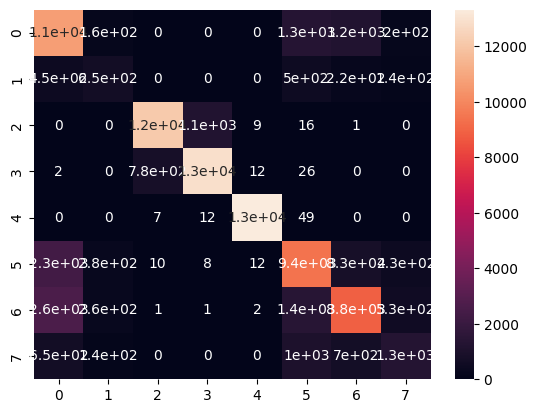

In [16]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [17]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [18]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, KNN_time]
results_dict["kNN"] = results

In [19]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [20]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.799156,0.798558,0.796156,0.799156,0.764652,0.728416,3.635527,1.906706,53.275805


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.789594    0.331807  0.911897  0.940063  0.994923  0.707112   
recall     0.640177    0.435247  0.938108  0.917022  0.997381  0.684920   
f1-score   0.707078    0.376552  0.924817  0.928399  0.996151  0.695839   

           Spoofing       Web  
precision  0.649494  0.337388  
recall     0.753063  0.493617  
f1-score   0.697454  0.400817  


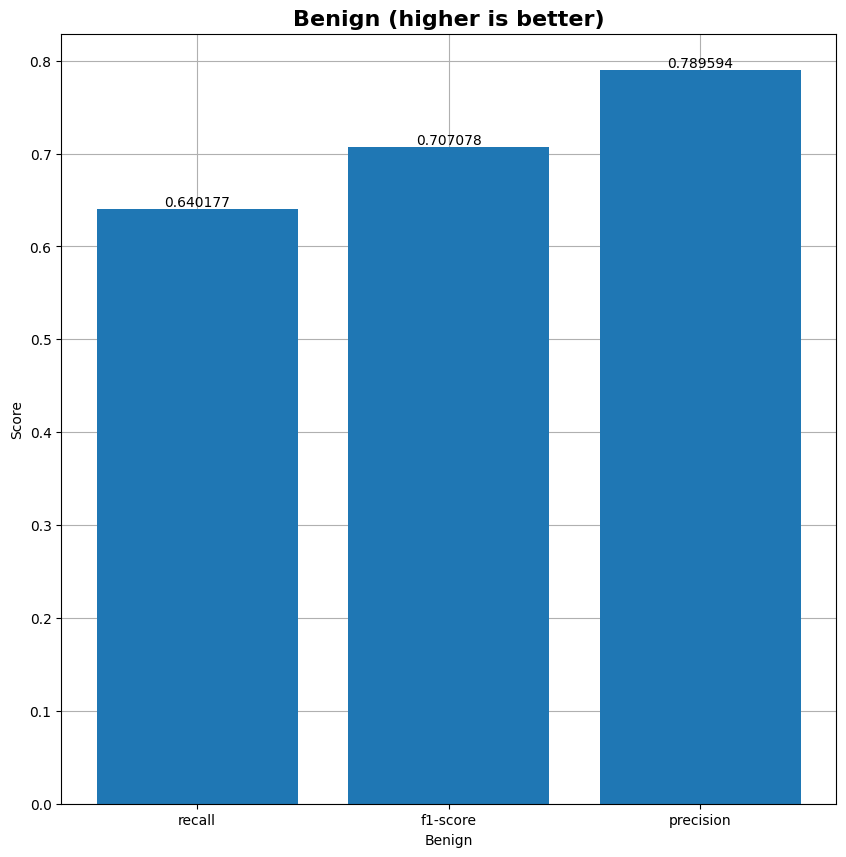

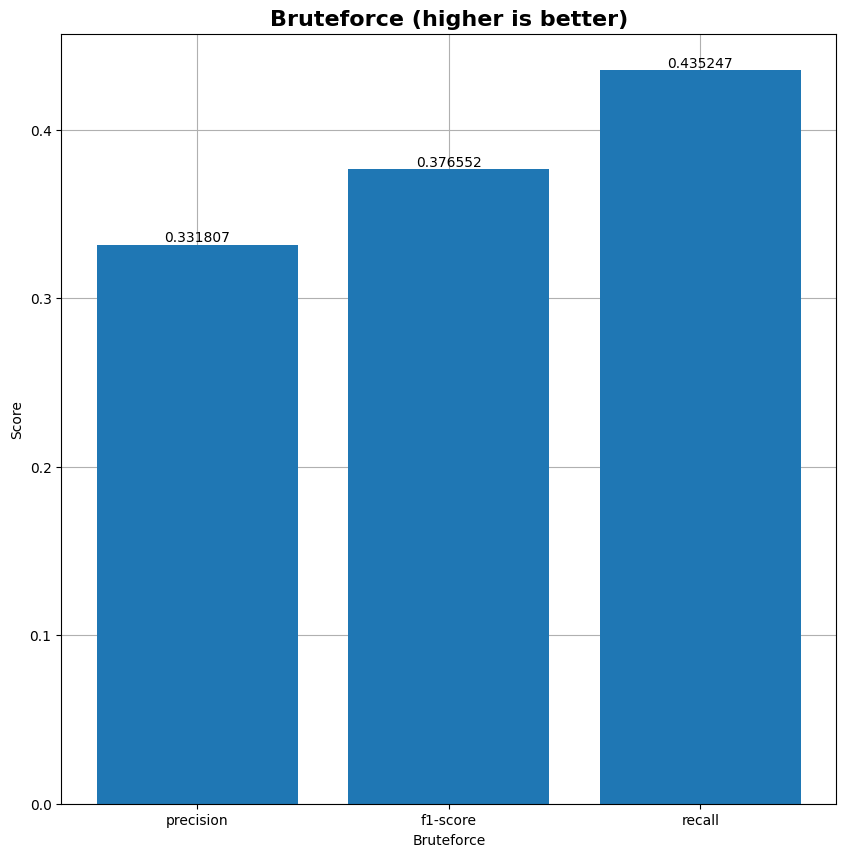

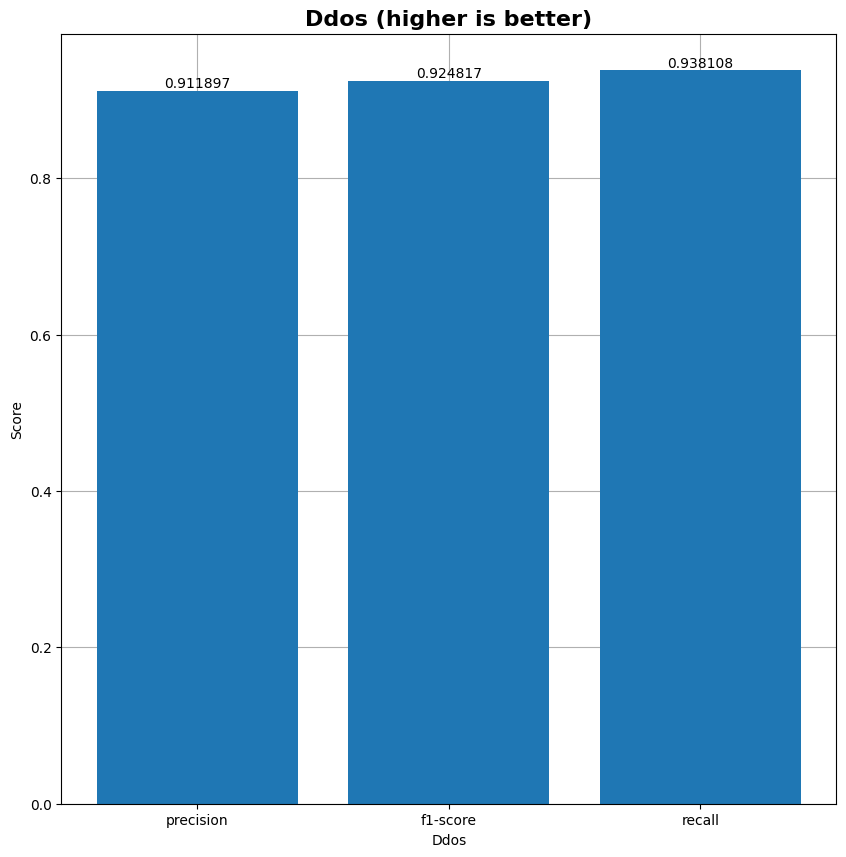

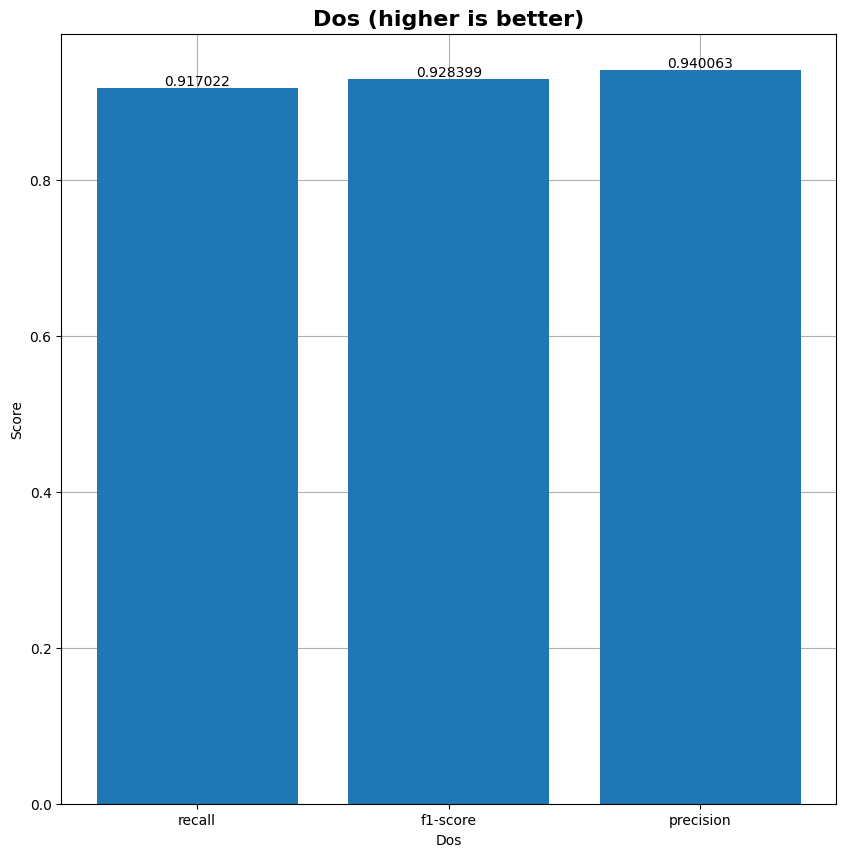

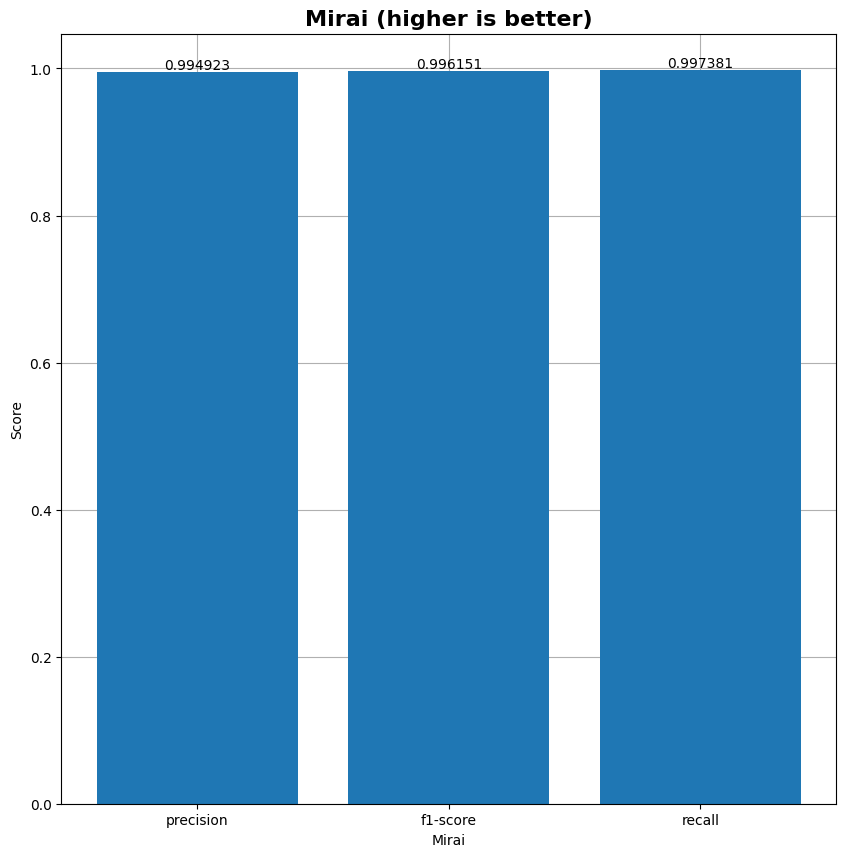

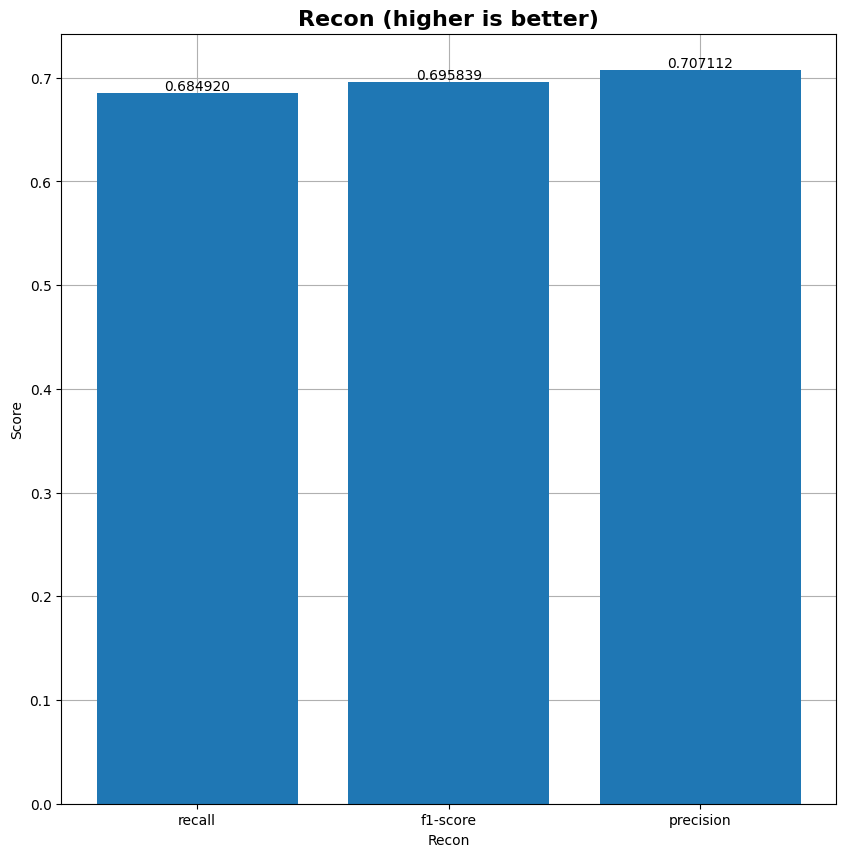

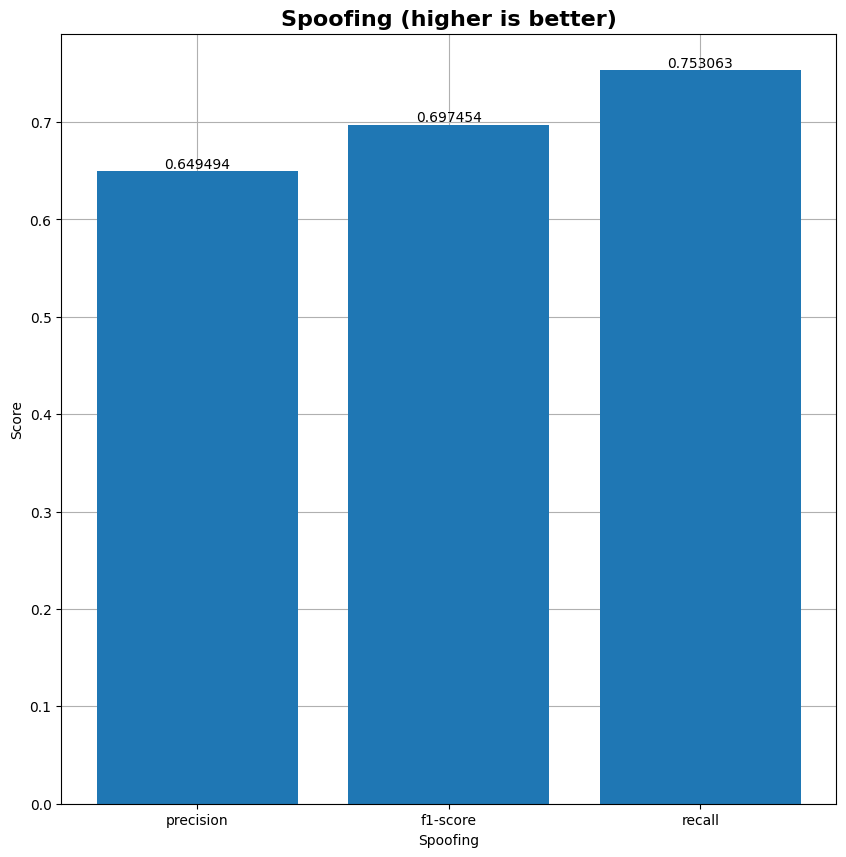

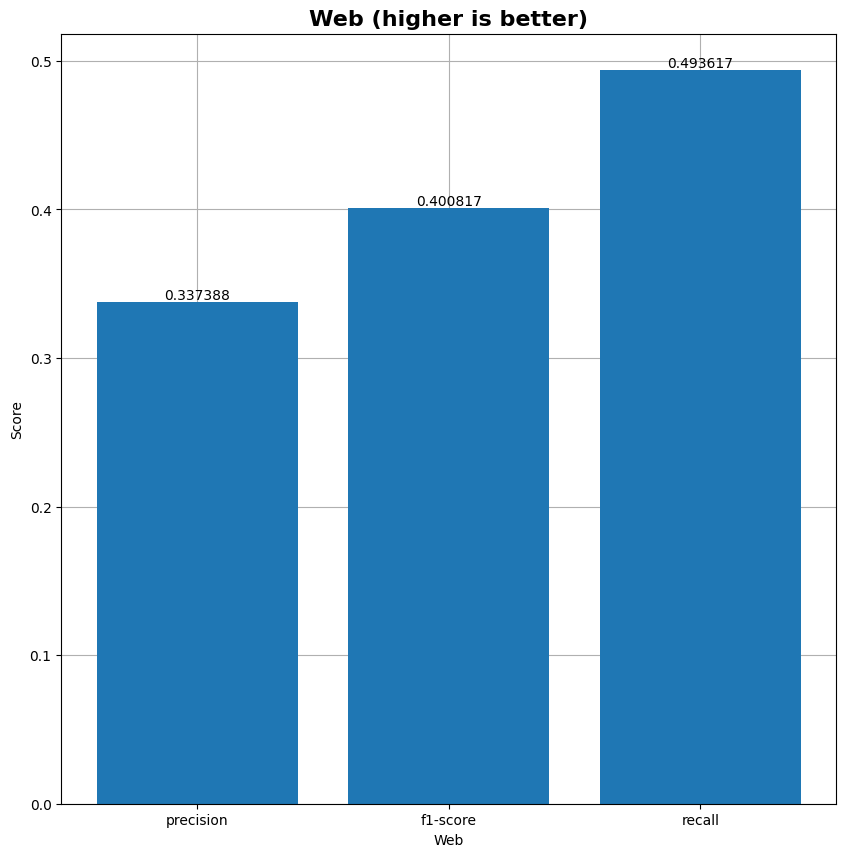

In [21]:
plot_mc(y_pred, y_test, "kNN")

In [22]:
model_name = "kNN_90000.sav"
pickle.dump(knn_clf, open(model_name, 'wb'))

# Random Forest

In [23]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 3min 56s, sys: 832 ms, total: 3min 57s
Wall time: 31.2 s


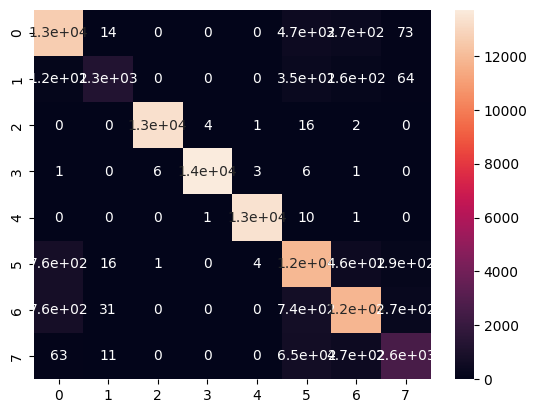

In [24]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [25]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [26]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [27]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [28]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.799156,0.798558,0.796156,0.799156,0.764652,0.728416,3.635527,1.906706,53.275805
RF,0.929653,0.930075,0.928756,0.929653,0.917444,0.237887,1.120864,1.058709,31.180870


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.931535    0.649873  0.998272  0.998762  0.999104  0.892046   
recall     0.881573    0.946627  0.999474  0.999636  0.999403  0.841381   
f1-score   0.905866    0.770670  0.998873  0.999199  0.999253  0.865973   

           Spoofing       Web  
precision  0.868340  0.682972  
recall     0.889357  0.811754  
f1-score   0.878723  0.741815  


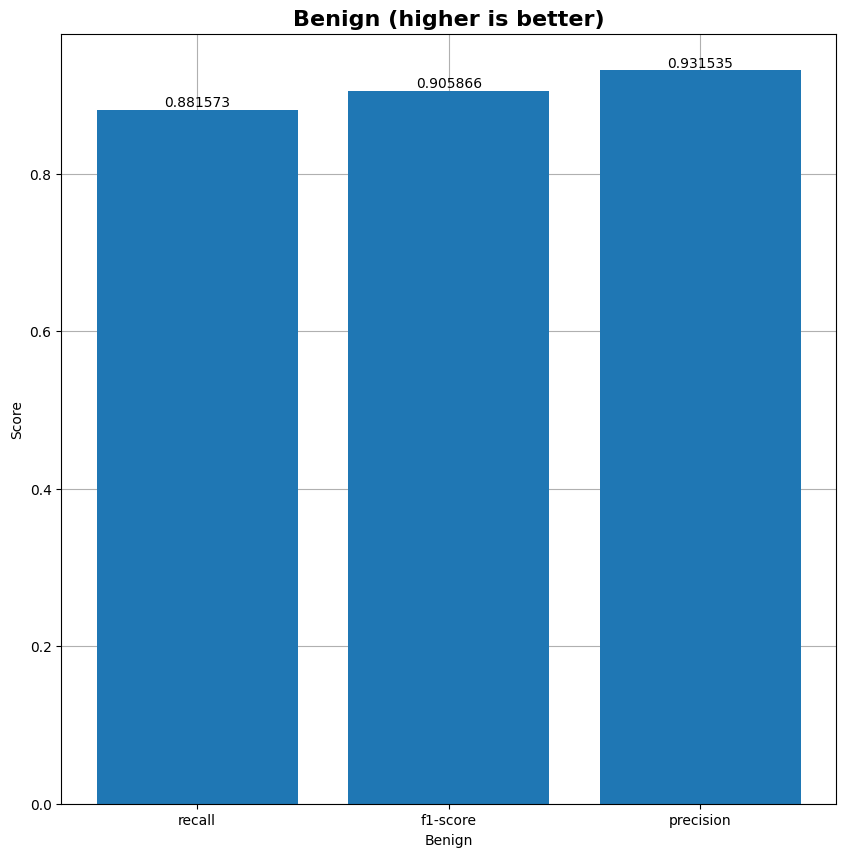

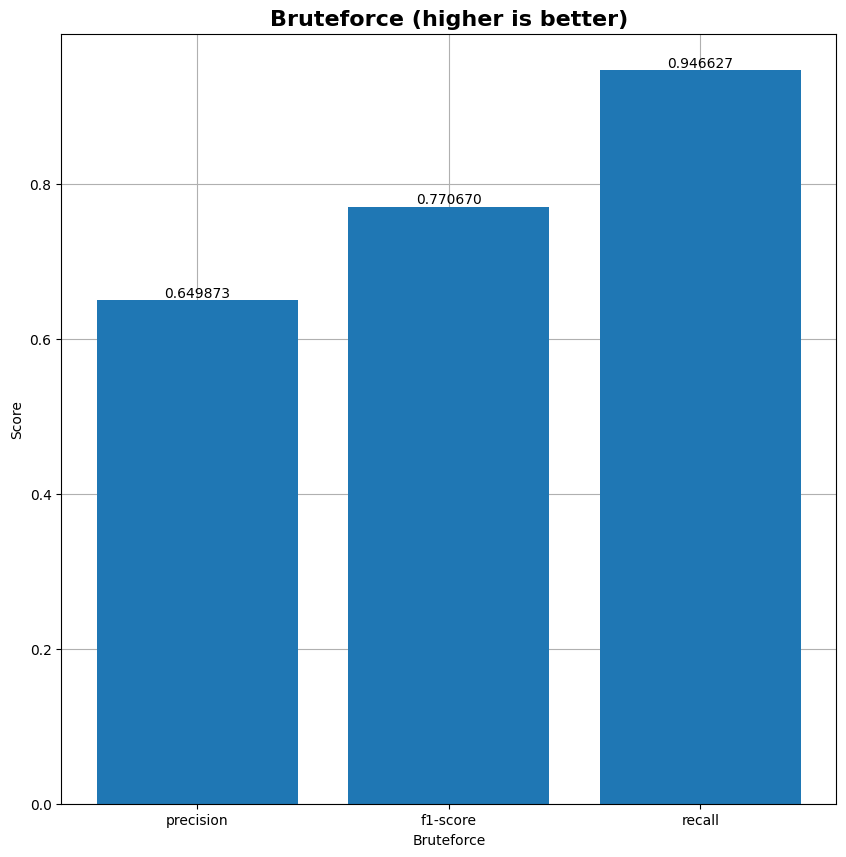

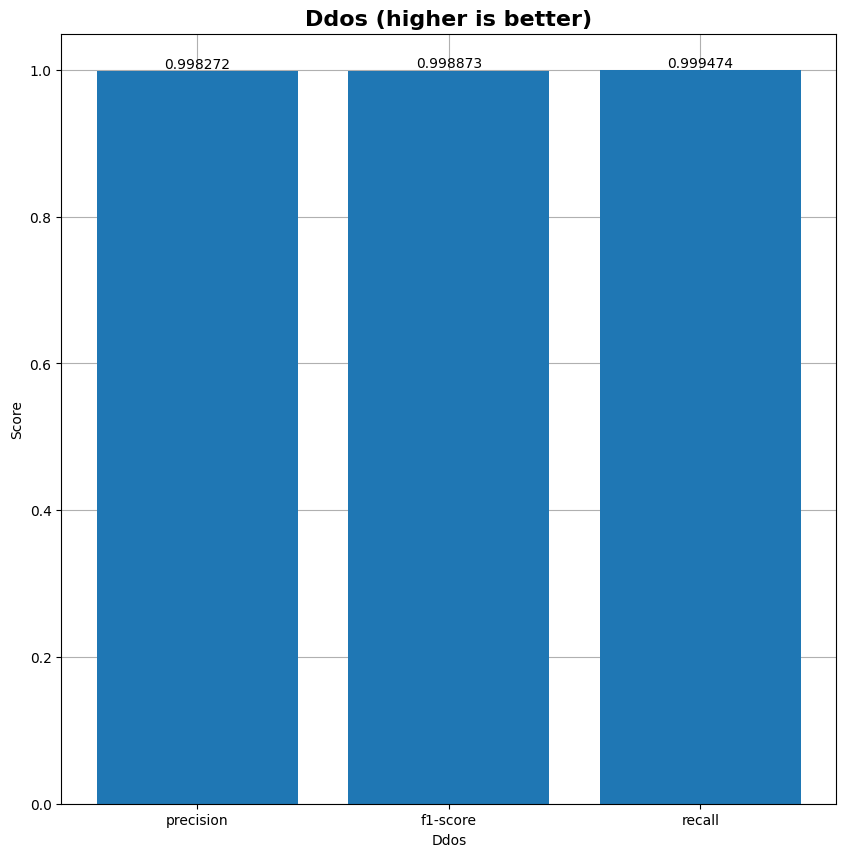

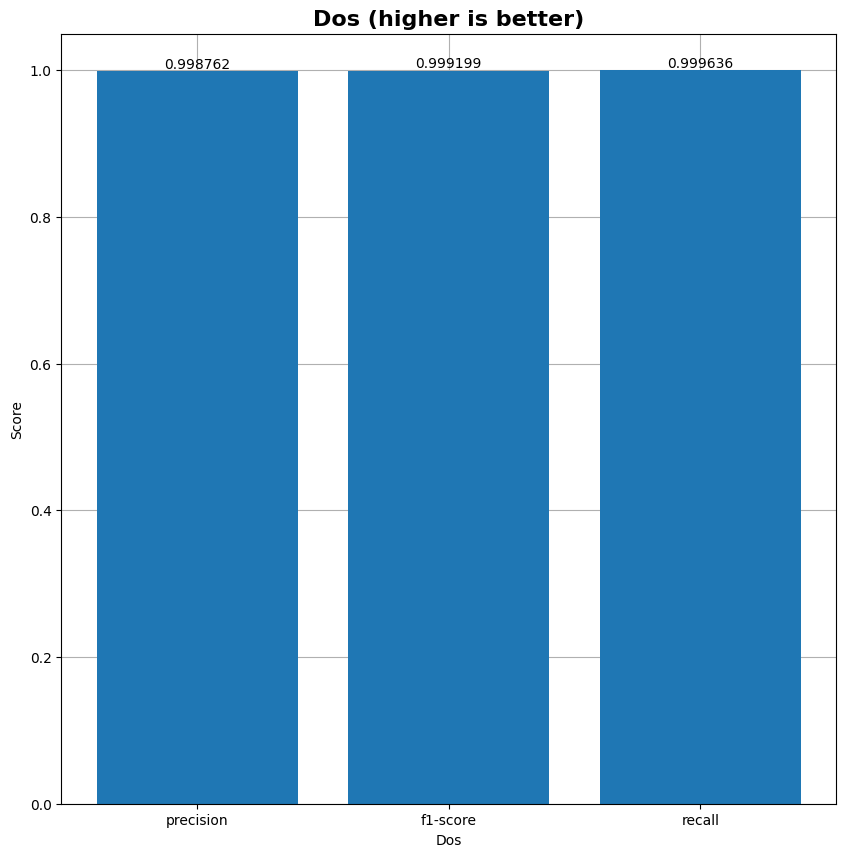

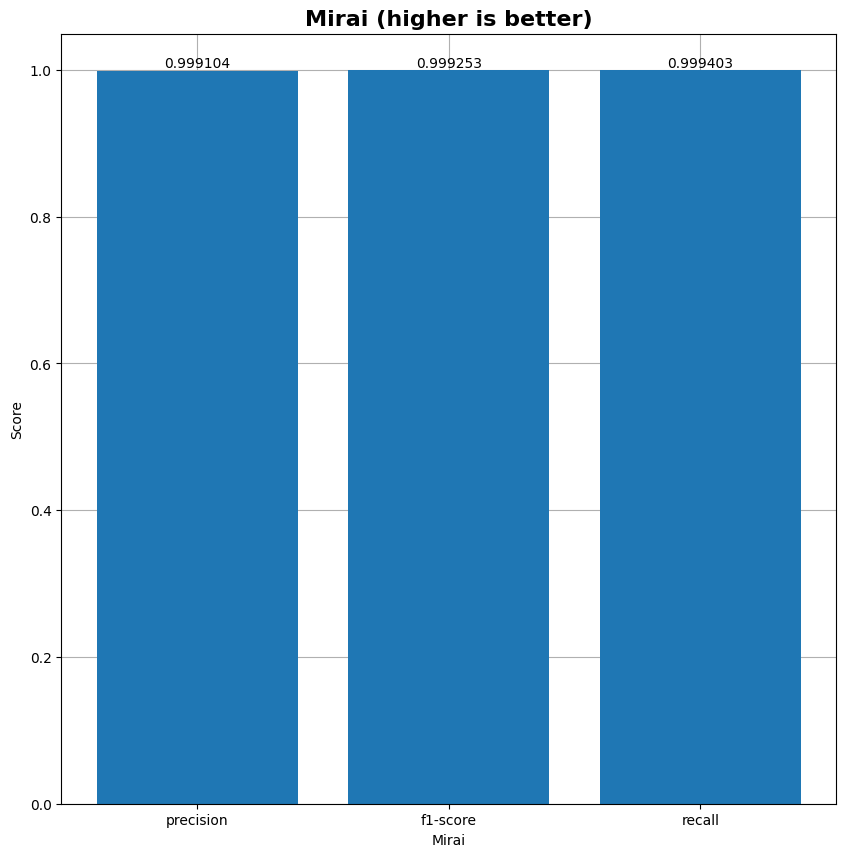

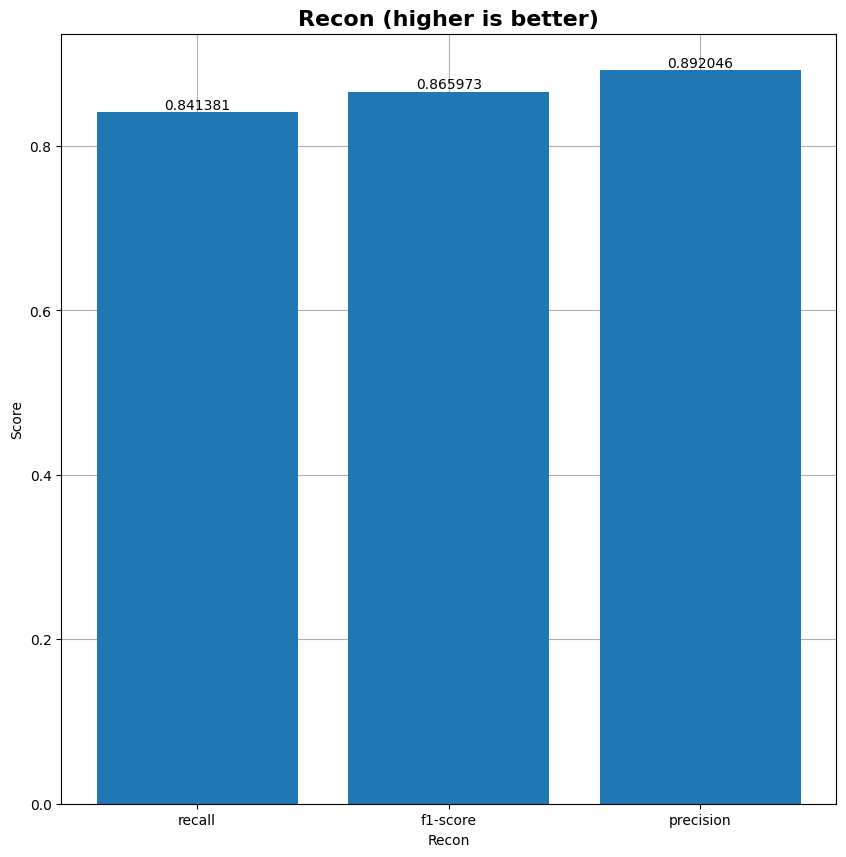

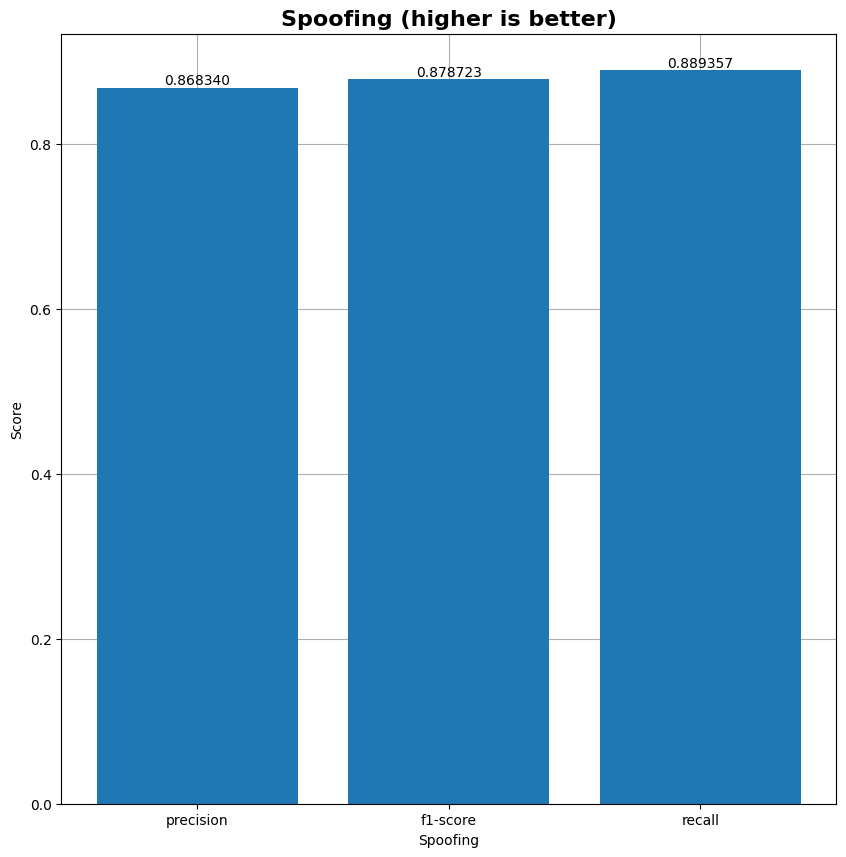

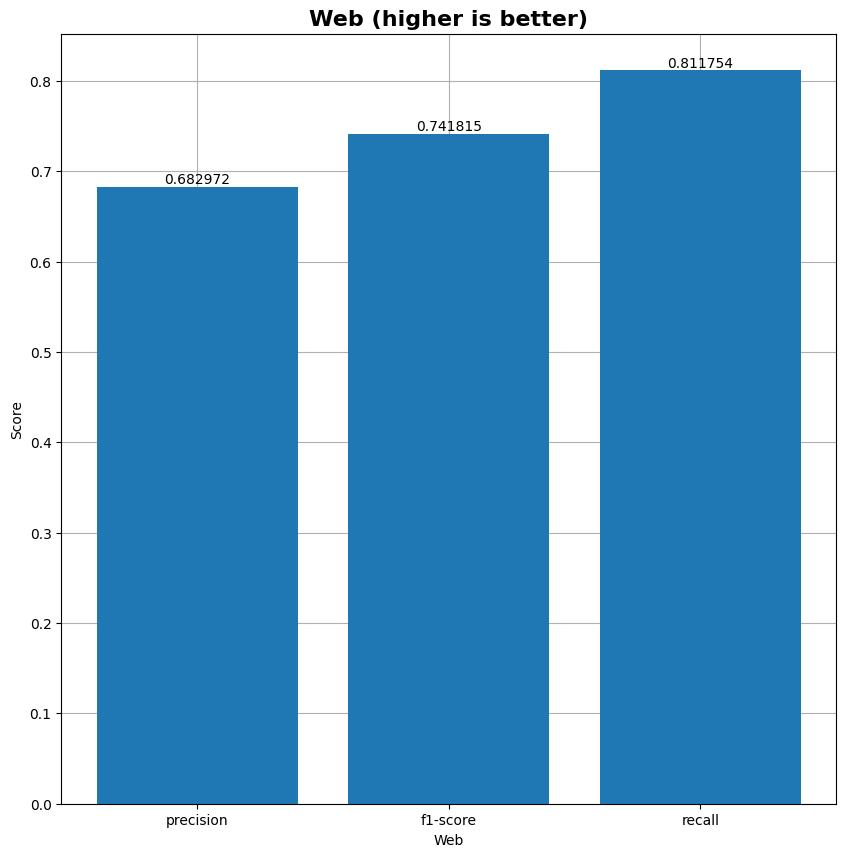

In [29]:
plot_mc(y_pred, y_test, "RF")

In [30]:
model_name = "RF_90000.sav"
pickle.dump(rf_clf, open(model_name, 'wb'))

# XGBoost

In [31]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 2min 14s, sys: 338 ms, total: 2min 14s
Wall time: 17.5 s


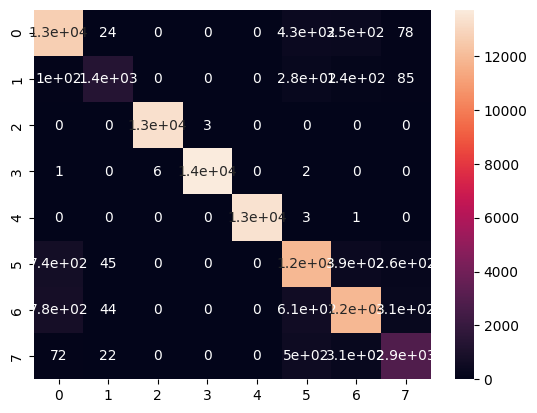

In [32]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [33]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [34]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [35]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [36]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.799156,0.798558,0.796156,0.799156,0.764652,0.728416,3.635527,1.906706,53.275805
RF,0.929653,0.930075,0.928756,0.929653,0.917444,0.237887,1.120864,1.058709,31.180870
XGBoost,0.935582,0.935828,0.935125,0.935582,0.924435,0.228439,1.102718,1.050104,17.478757


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.935588    0.688041  0.999775  0.999345  0.999701  0.892347   
recall     0.882026    0.909213  0.999549  0.999781  1.000000  0.866613   
f1-score   0.908018    0.783314  0.999662  0.999563  0.999851  0.879292   

           Spoofing       Web  
precision  0.871716  0.761766  
recall     0.909564  0.796957  
f1-score   0.890238  0.778964  


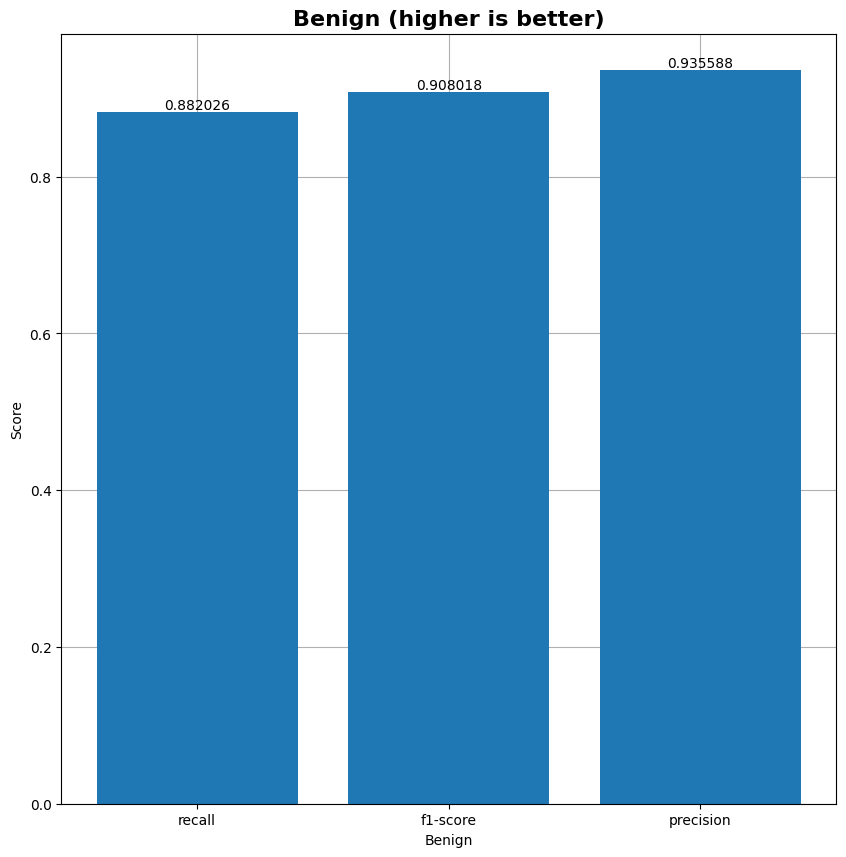

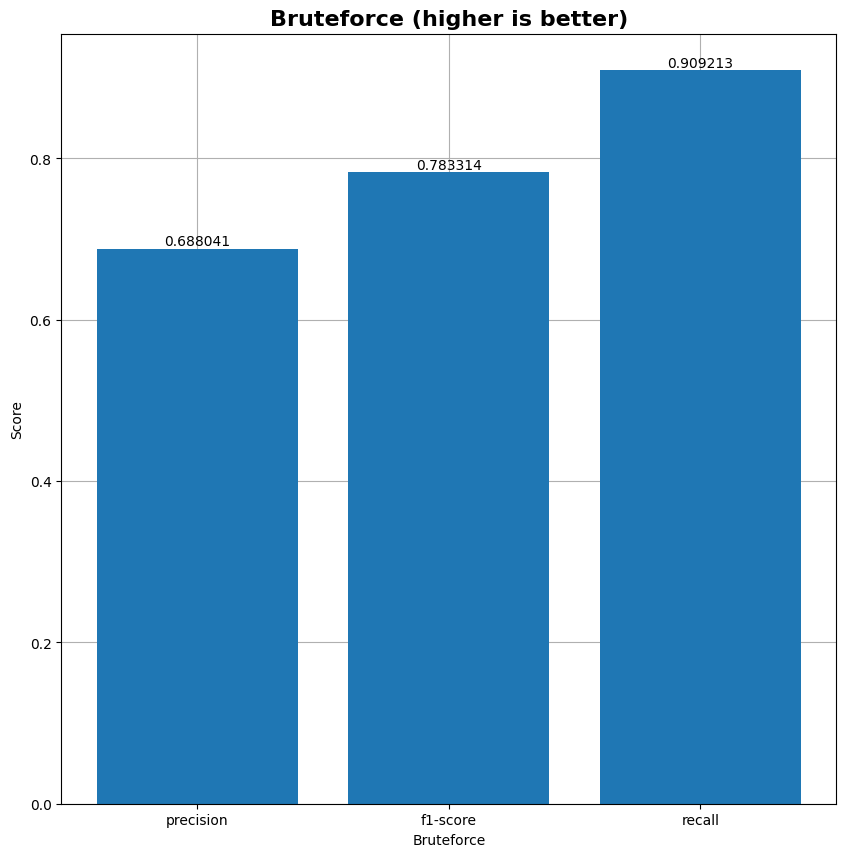

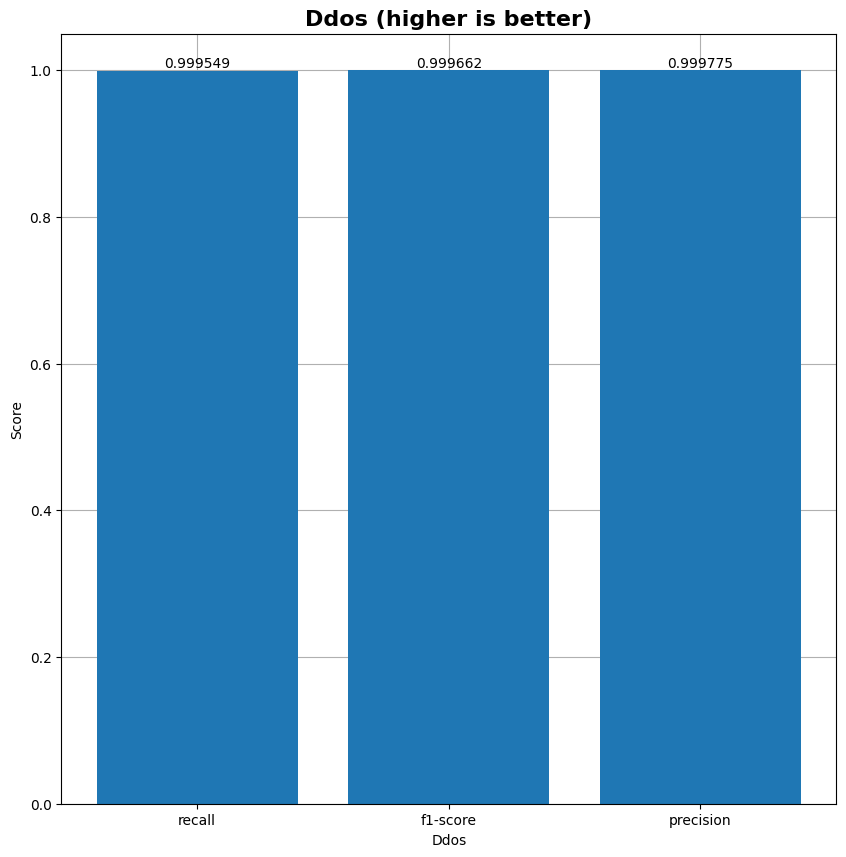

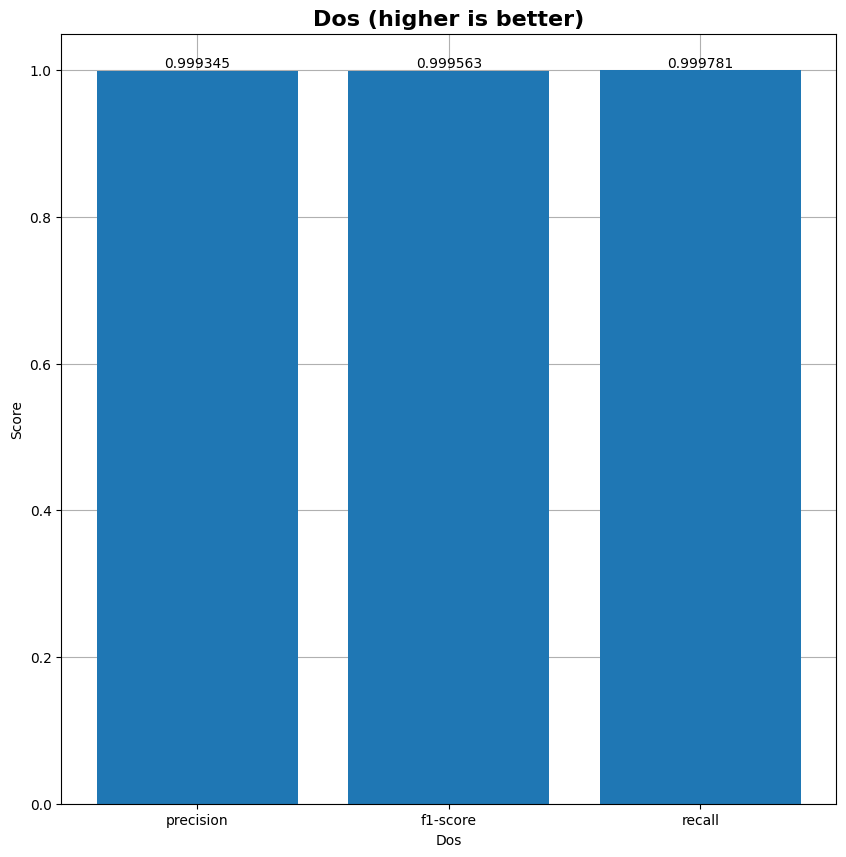

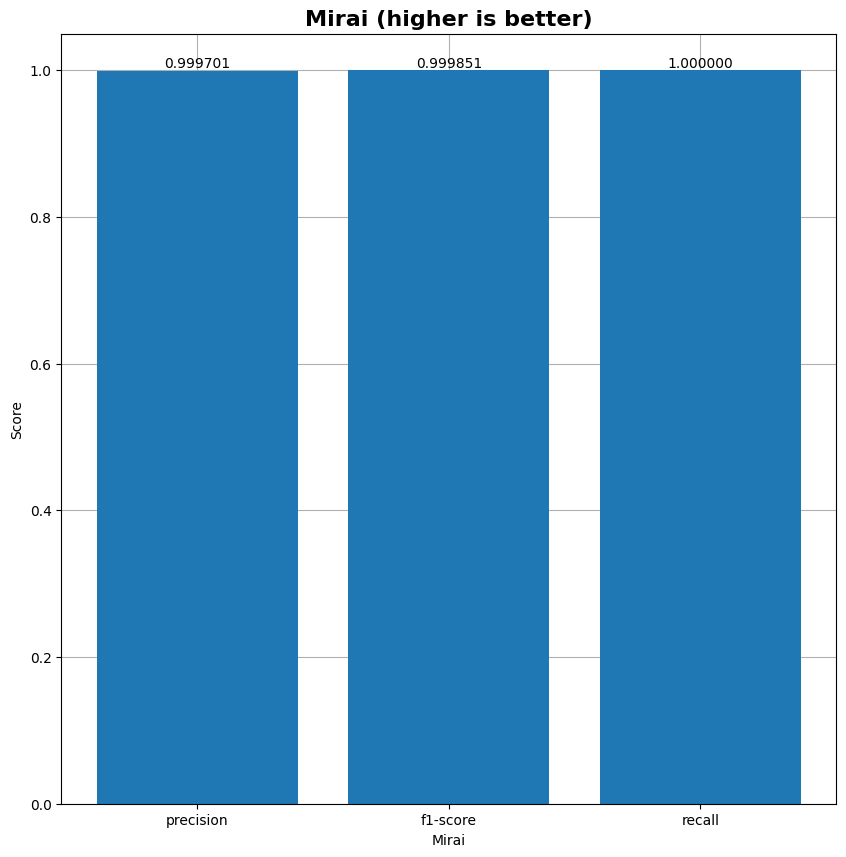

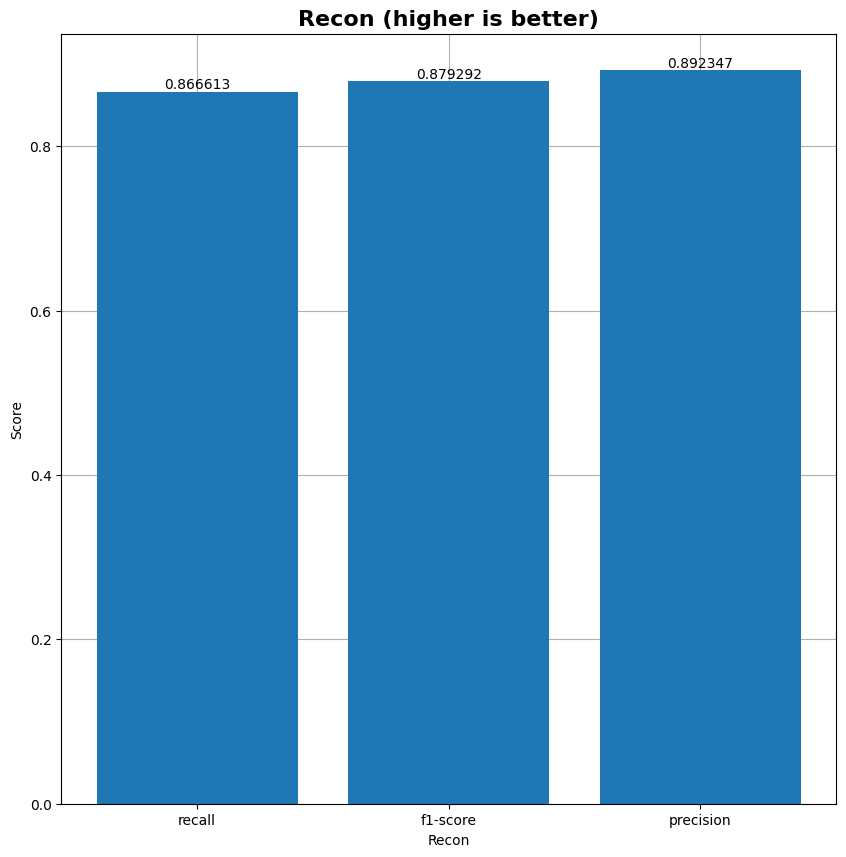

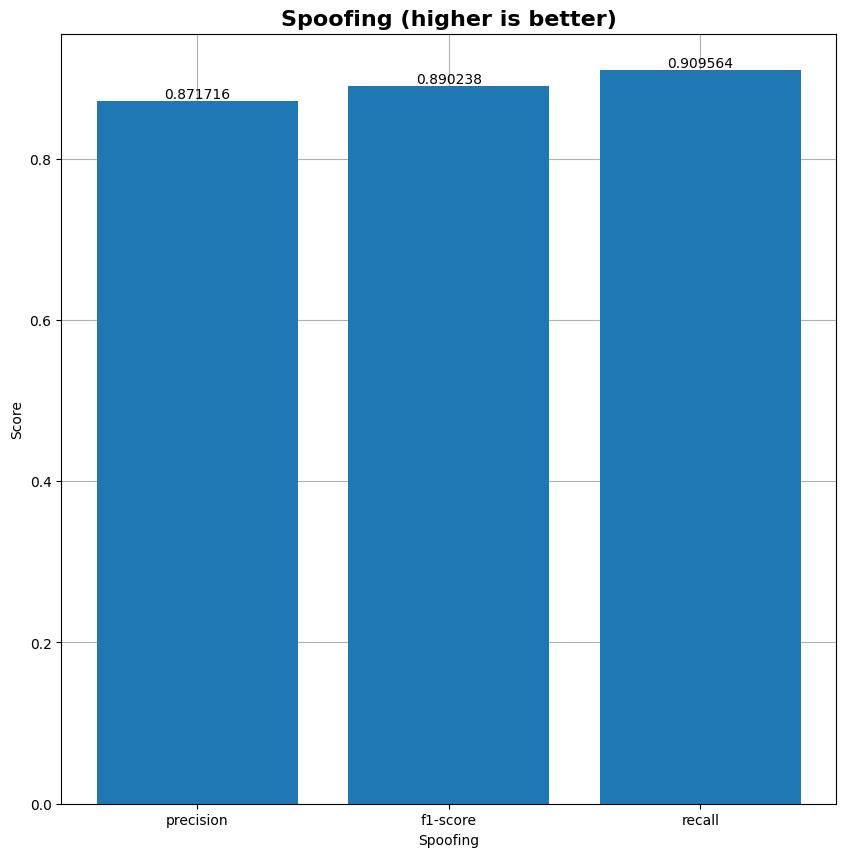

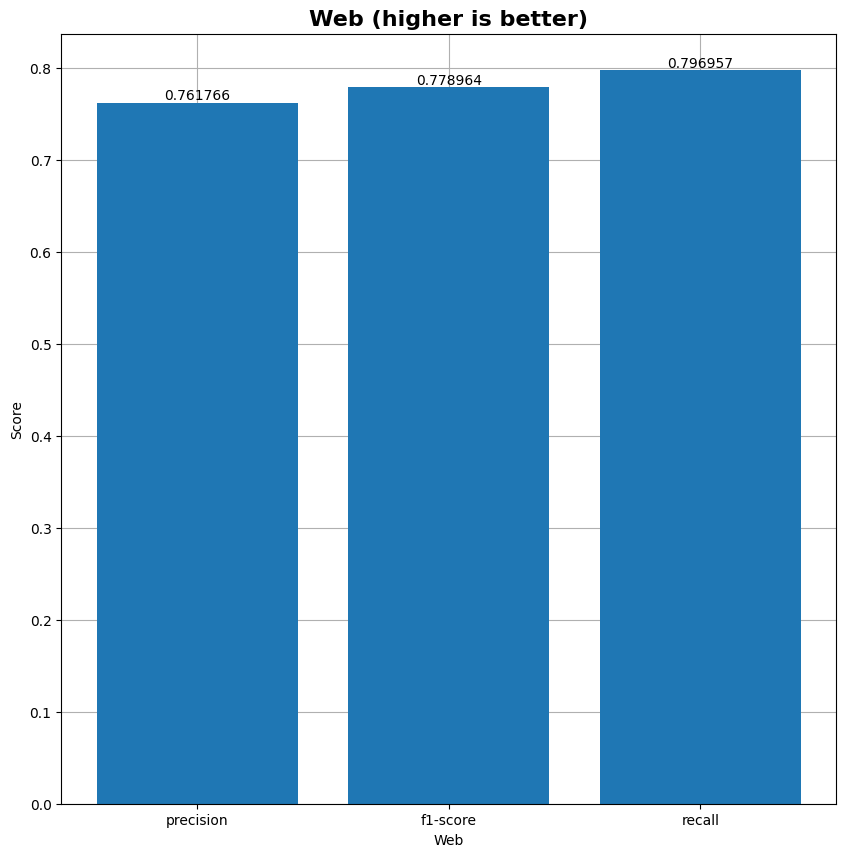

In [37]:
plot_mc(y_pred, y_test, "XGBoost")

In [38]:
model_name = "XGB_90000.sav"
pickle.dump(xgb_clf, open(model_name, 'wb'))

# LightGBM

In [39]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5380
[LightGBM] [Info] Number of data points in the train set: 491209, number of used features: 39
[LightGBM] [Info] Start training from score -1.860481
[LightGBM] [Info] Start training from score -3.790015
[LightGBM] [Info] Start training from score -1.857151
[LightGBM] [Info] Start training from score -1.862603
[LightGBM] [Info] Start training from score -1.858207
[LightGBM] [Info] Start training from score -1.856994
[LightGBM] [Info] Start training from score -1.861227
[LightGBM] [Info] Start training from score -3.150112


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CPU times: user 56.5 s, sys: 172 ms, total: 56.7 s
Wall time: 14.5 s


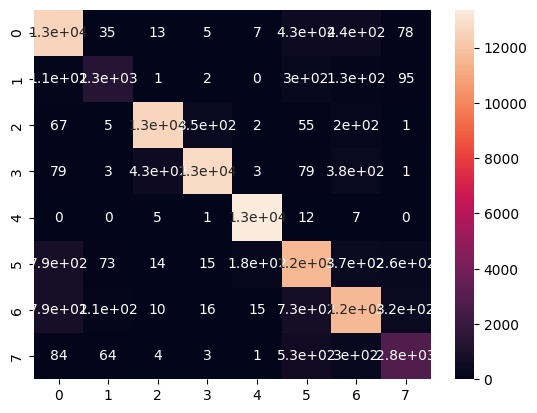

In [40]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [41]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [42]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LightGBM_Time]
results_dict["LightGBM"] = results

In [43]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [44]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.799156,0.798558,0.796156,0.799156,0.764652,0.728416,3.635527,1.906706,53.275805
RF,0.929653,0.930075,0.928756,0.929653,0.917444,0.237887,1.120864,1.058709,31.180870
XGBoost,0.935582,0.935828,0.935125,0.935582,0.924435,0.228439,1.102718,1.050104,17.478757
LightGBM,0.907607,0.907984,0.907327,0.907607,0.891601,0.295960,1.335621,1.155691,14.549309


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.925860    0.676336  0.948776  0.928920  0.998134  0.871373   
recall     0.867491    0.822910  0.963539  0.970036  0.984391  0.844271   
f1-score   0.895726    0.742458  0.956101  0.949033  0.991215  0.857608   

           Spoofing       Web  
precision  0.854323  0.738763  
recall     0.864538  0.786599  
f1-score   0.859400  0.761931  


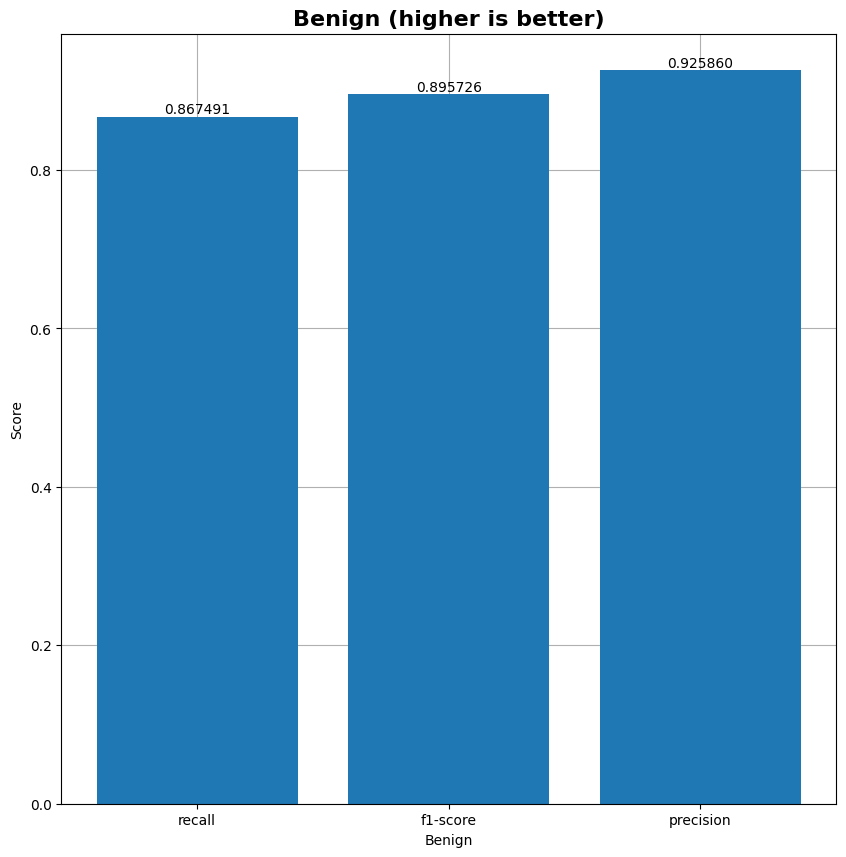

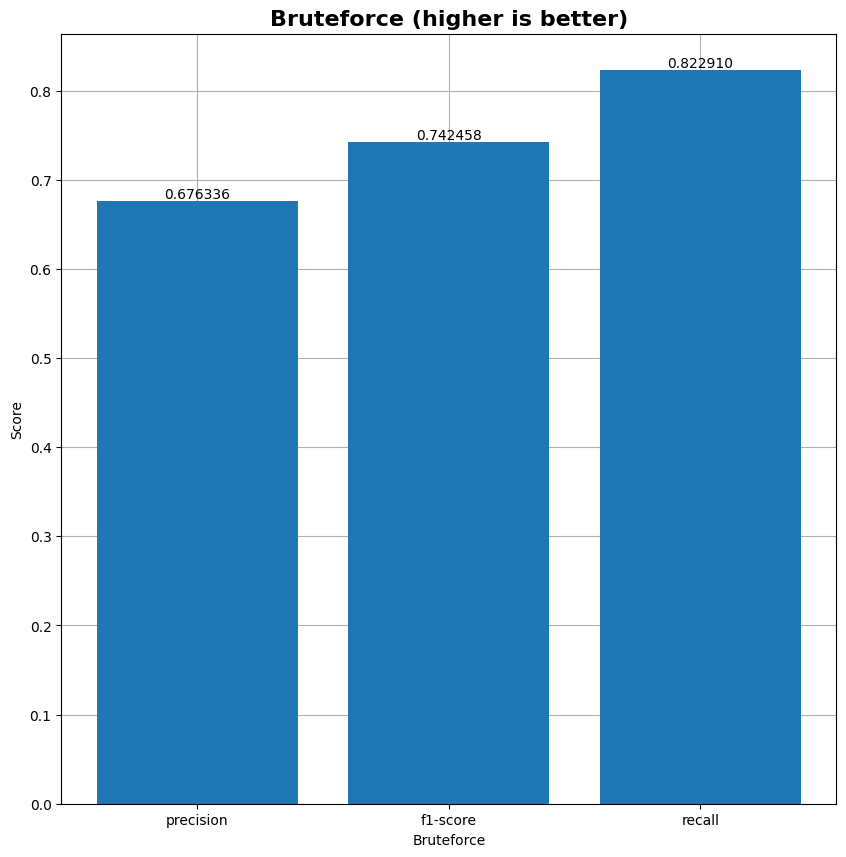

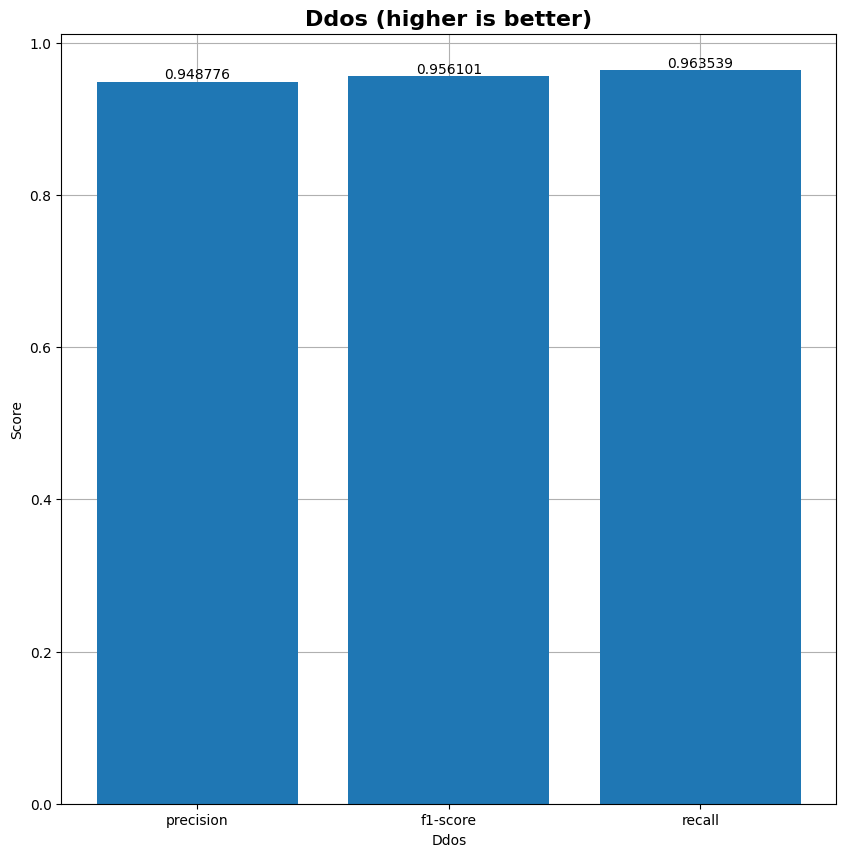

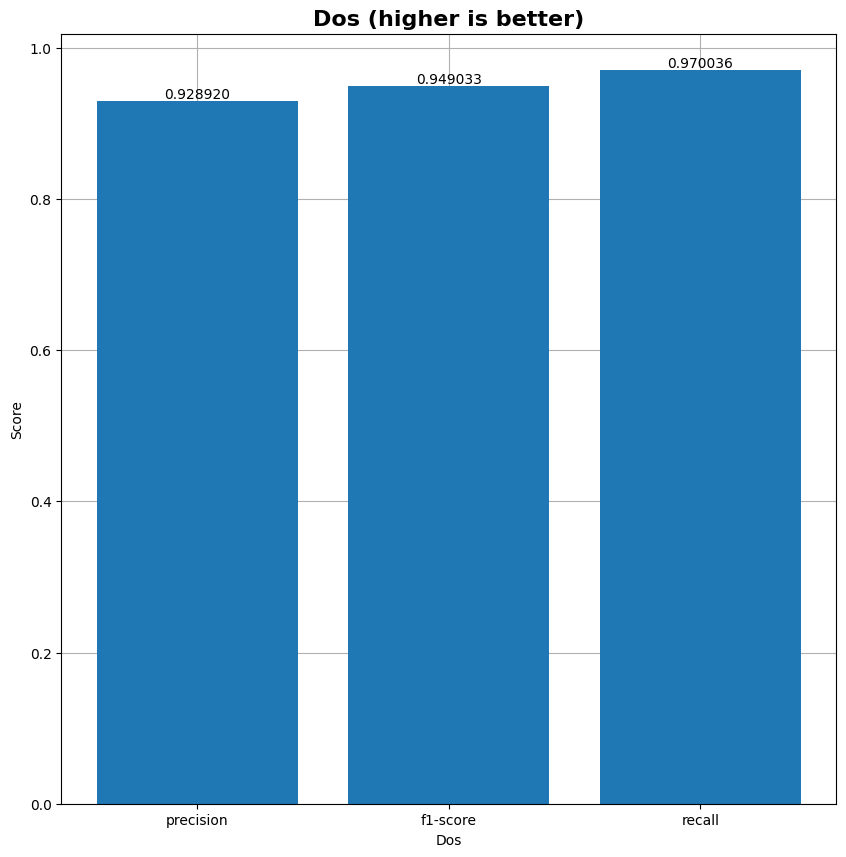

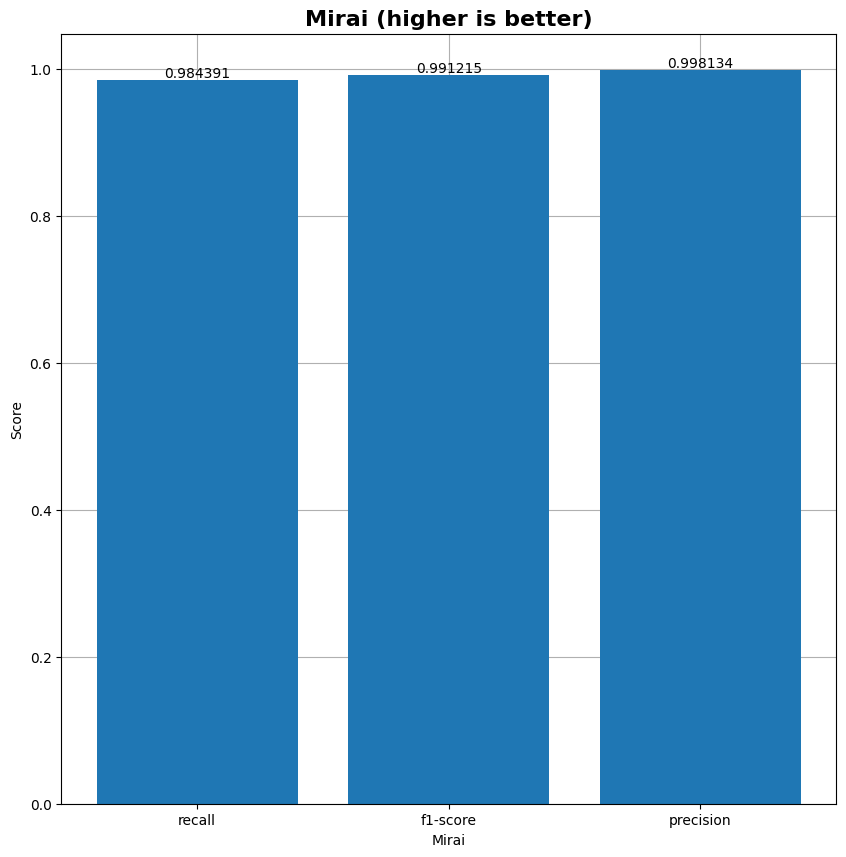

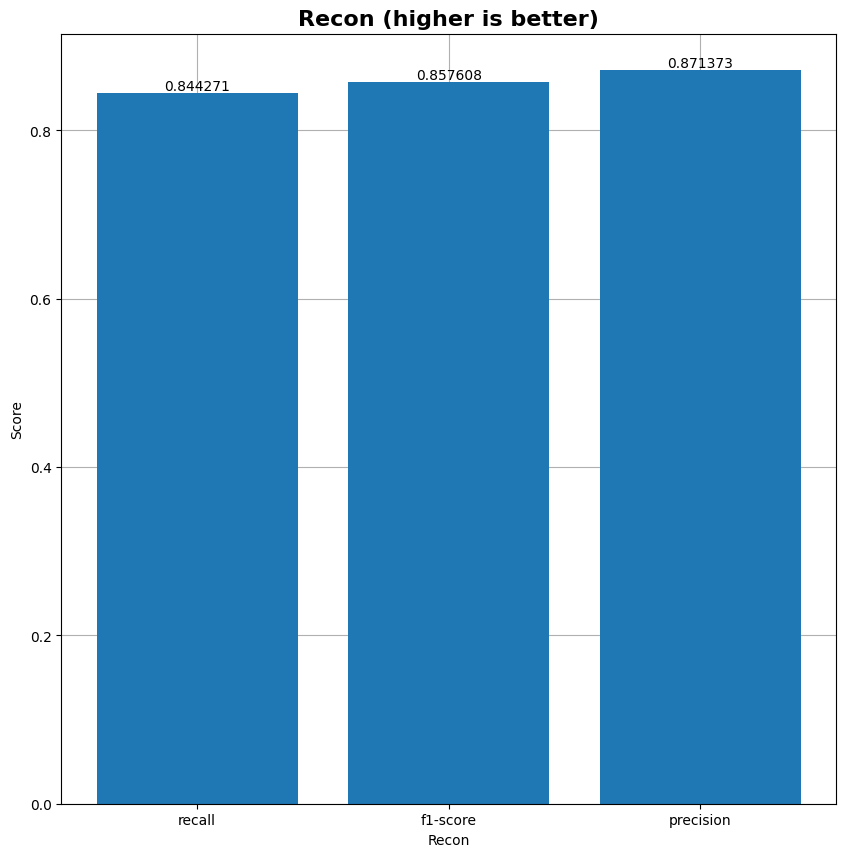

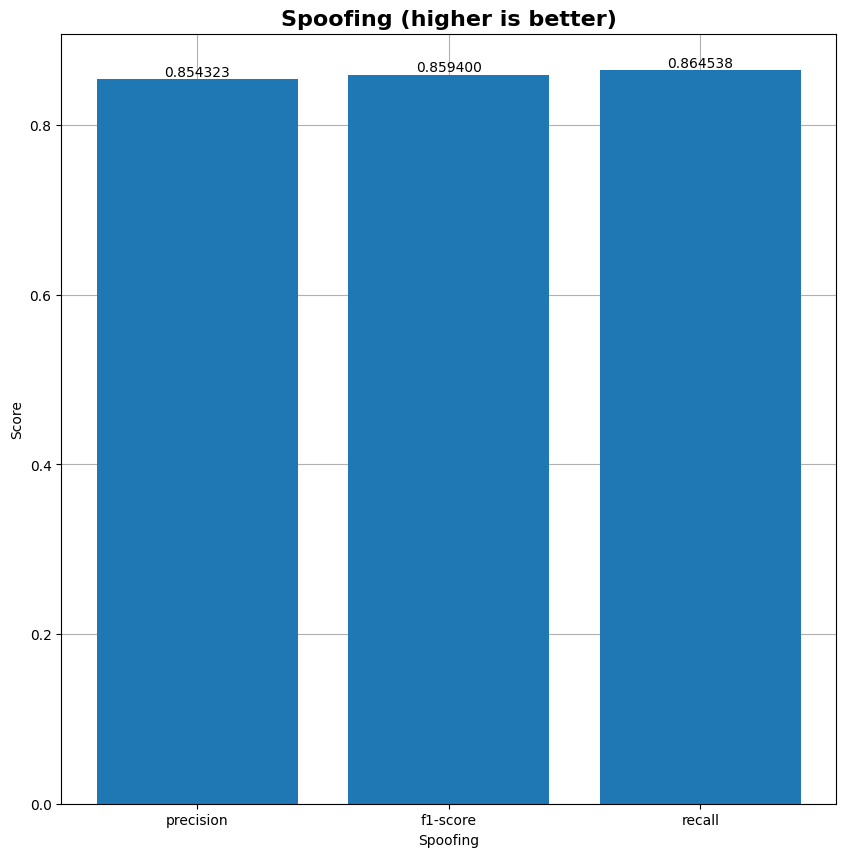

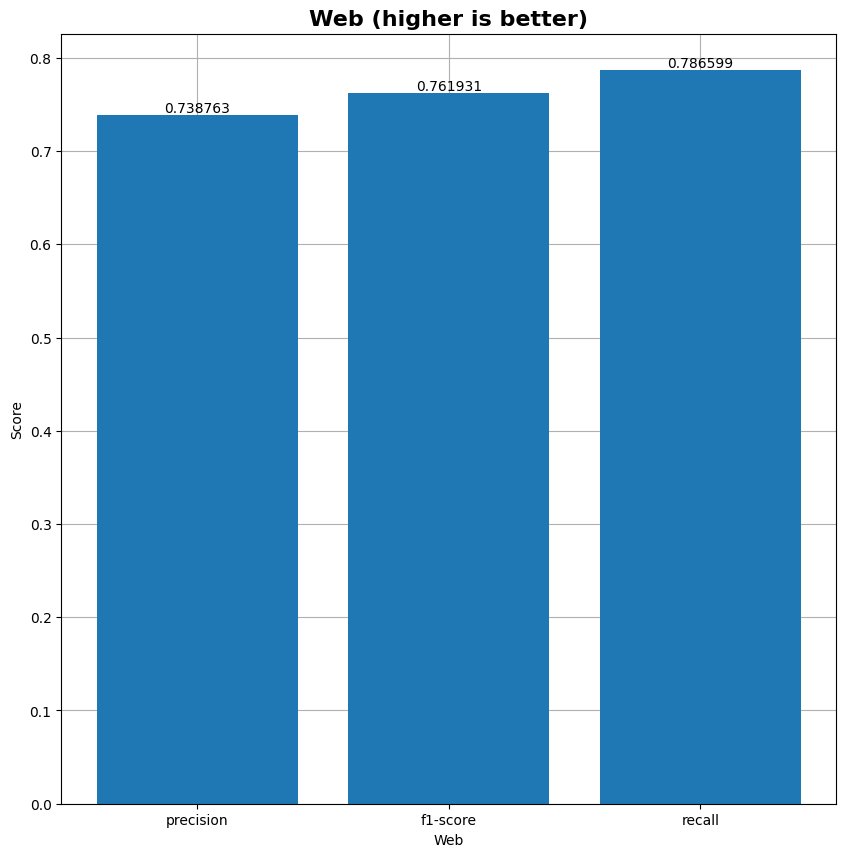

In [45]:
plot_mc(y_pred, y_test, "LightGBM")

In [46]:
model_name = "LightGBM_90000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# Feed Forward Neural Network

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((402791, 46), (402791,), (88418, 46), (88418,), (86684, 46), (86684,))

In [48]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744615348.326545    2864 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5151 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [49]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,194 (2.21 MB)

 Trainable params: 579,194 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

Epoch 1/20


I0000 00:00:1744615351.890273    5511 service.cc:152] XLA service 0x7f291c009b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744615351.890287    5511 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-04-14 10:22:31.991106: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744615352.293981    5511 cuda_dnn.cc:529] Loaded cuDNN version 90300


   75/25175 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - accuracy: 0.5006 - loss: 1.3750    

I0000 00:00:1744615353.505438    5511 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25175/25175 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.7306 - loss: 0.6288 - val_accuracy: 0.7645 - val_loss: 0.5360
Epoch 2/20
25175/25175 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.7724 - loss: 0.5247 - val_accuracy: 0.7755 - val_loss: 0.5277
Epoch 3/20
25175/25175 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.7824 - loss: 0.5086 - val_accuracy: 0.7827 - val_loss: 0.5025
Epoch 4/20
25175/25175 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.7839 - loss: 0.4991 - val_accuracy: 0.7862 - val_loss: 0.4980
Epoch 5/20
25175/25175 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.7875 - loss: 0.5217 - val_accuracy: 0.7870 - val_loss: 0.4972
Epoch 6/20
25175/25175 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.7896 - loss: 0.4887 - val_accuracy: 0.7879 - val_loss: 0.5032
Epoch 7/20
25175/25175 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.7898 - loss: 0.4872 - val_accuracy: 0.7859 - val_loss: 0.4985
Epoch 8/20
25175/25175 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.7915 - lo

In [51]:
y_pred = np.argmax(y_pred, axis=1)

In [52]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

2709/2709 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7937 - loss: 0.4991


In [53]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, FFNN_Time]
results_dict["FF-NN"] = results

In [54]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [55]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.799156,0.798558,0.796156,0.799156,0.764652,0.728416,3.635527,1.906706,53.275805
RF,0.929653,0.930075,0.928756,0.929653,0.917444,0.237887,1.120864,1.058709,31.180870
XGBoost,0.935582,0.935828,0.935125,0.935582,0.924435,0.228439,1.102718,1.050104,17.478757
LightGBM,0.907607,0.907984,0.907327,0.907607,0.891601,0.295960,1.335621,1.155691,14.549309
FF-NN,0.792811,0.790112,0.785825,0.792811,0.756313,0.567948,2.502538,1.581941,1162.719425


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.868631    0.329870  0.775225  0.827976  0.994528  0.737298   
recall     0.755152    0.639476  0.825598  0.787935  0.998145  0.734903   
f1-score   0.807926    0.435230  0.799619  0.807459  0.996333  0.736099   

           Spoofing       Web  
precision  0.764541  0.259028  
recall     0.699980  0.644595  
f1-score   0.730837  0.369553  


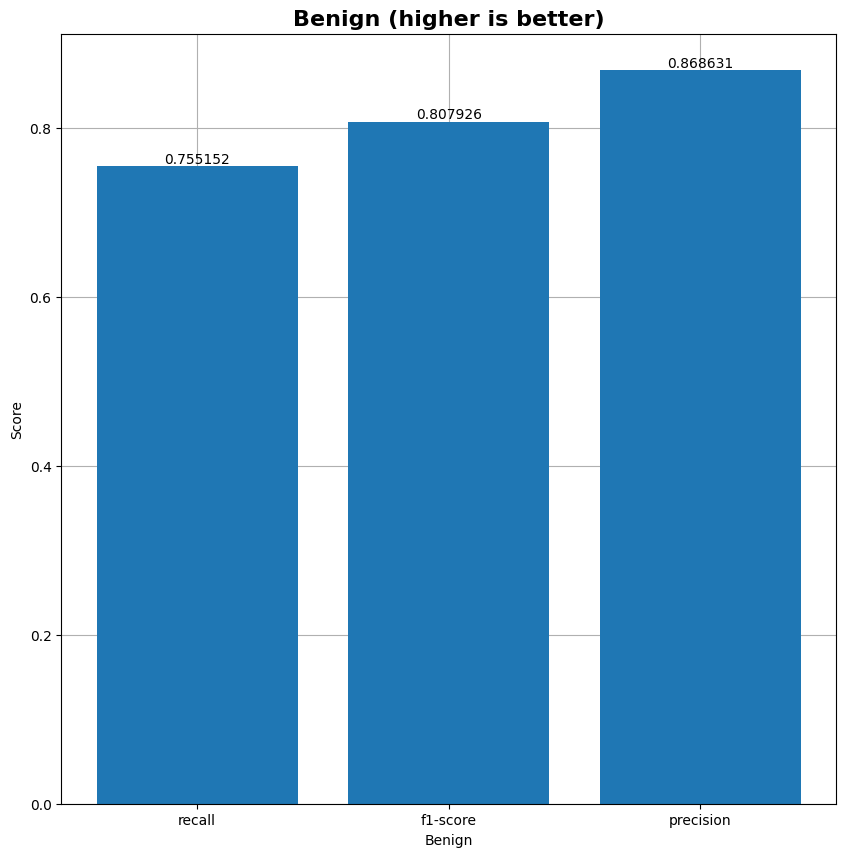

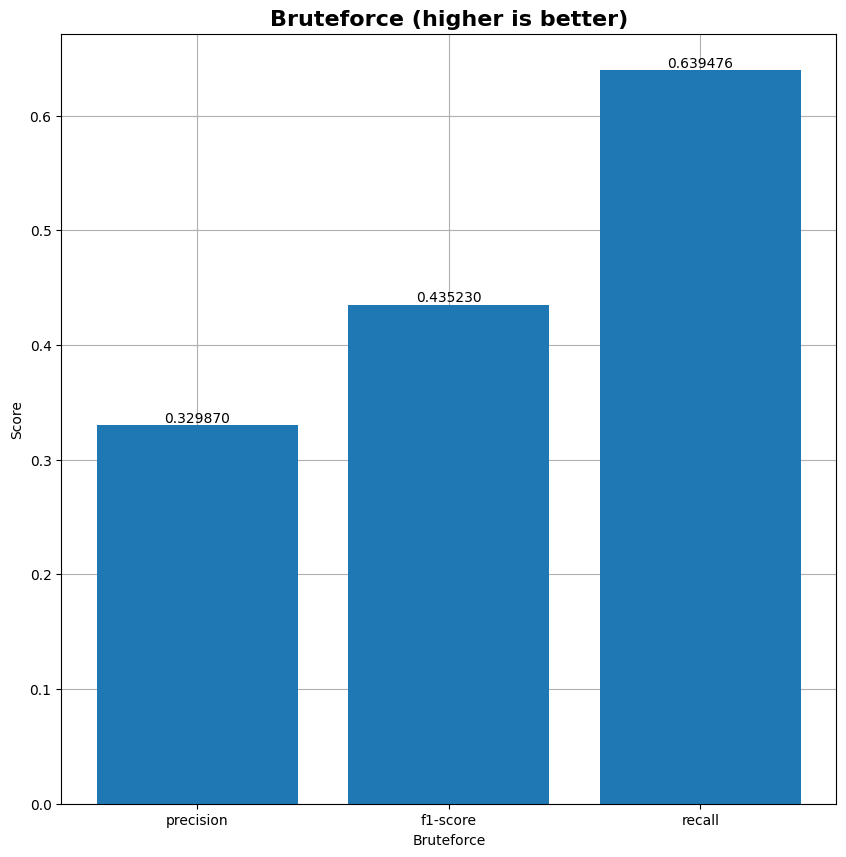

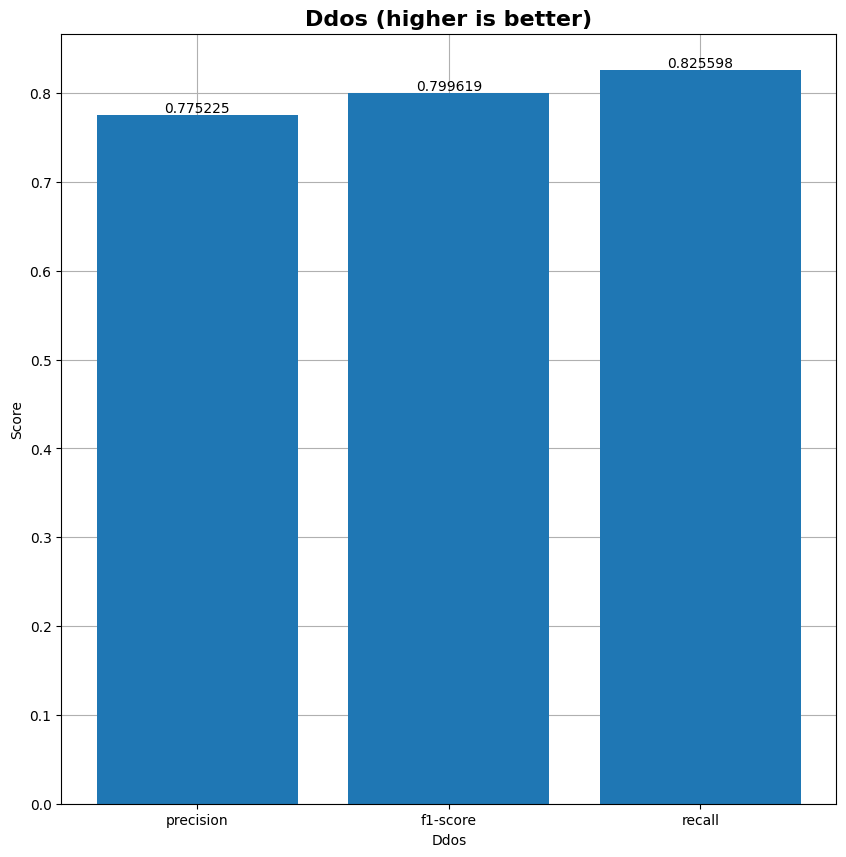

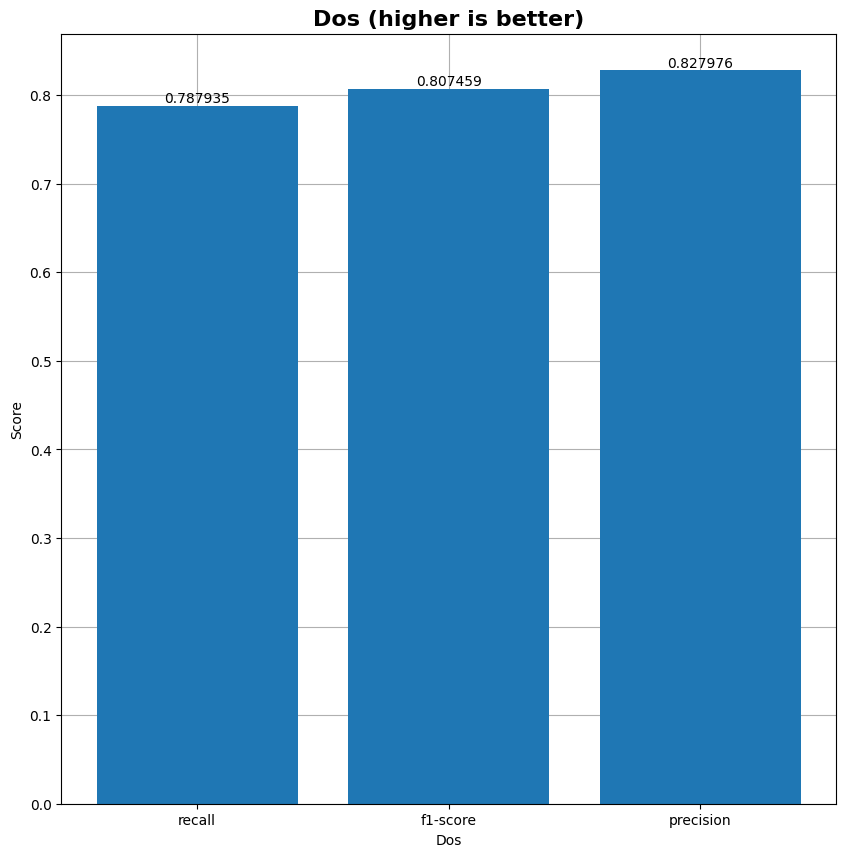

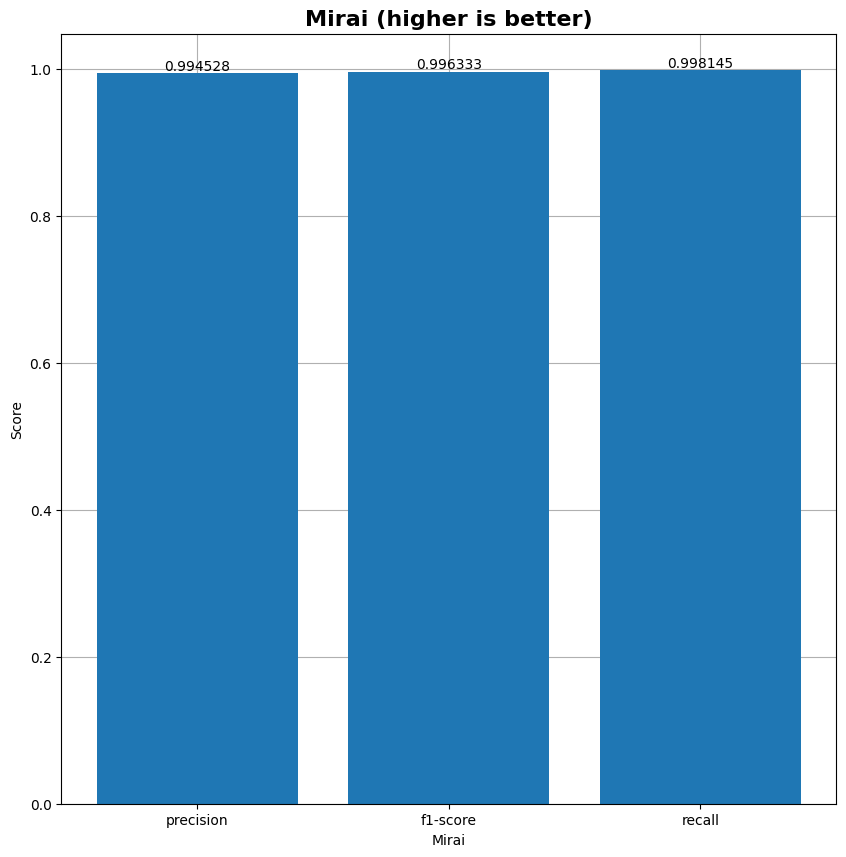

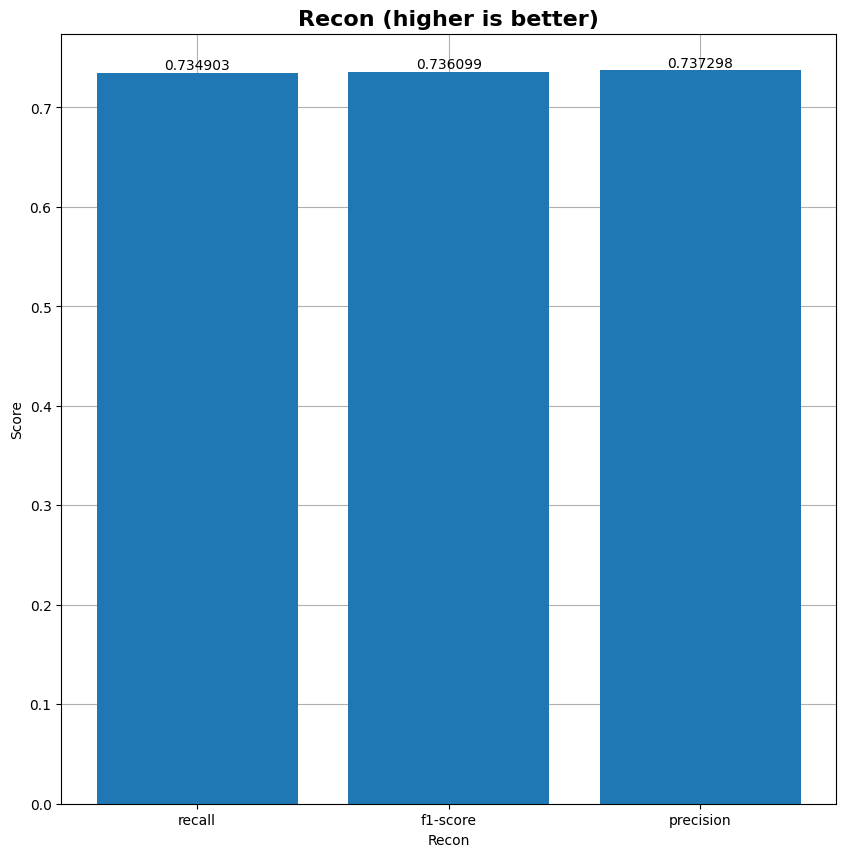

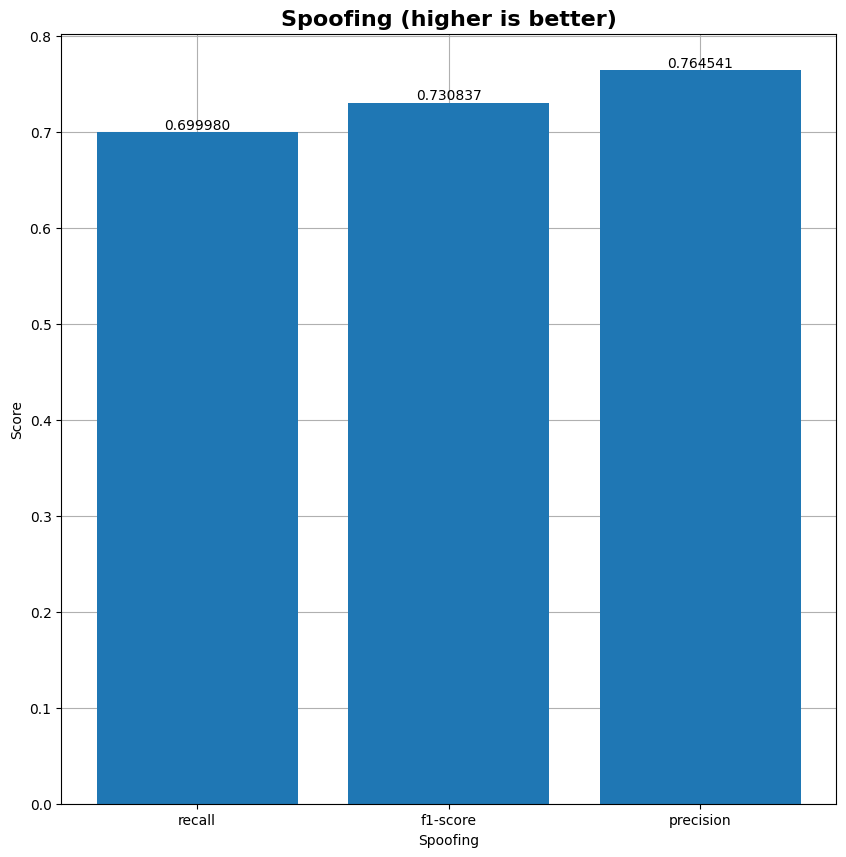

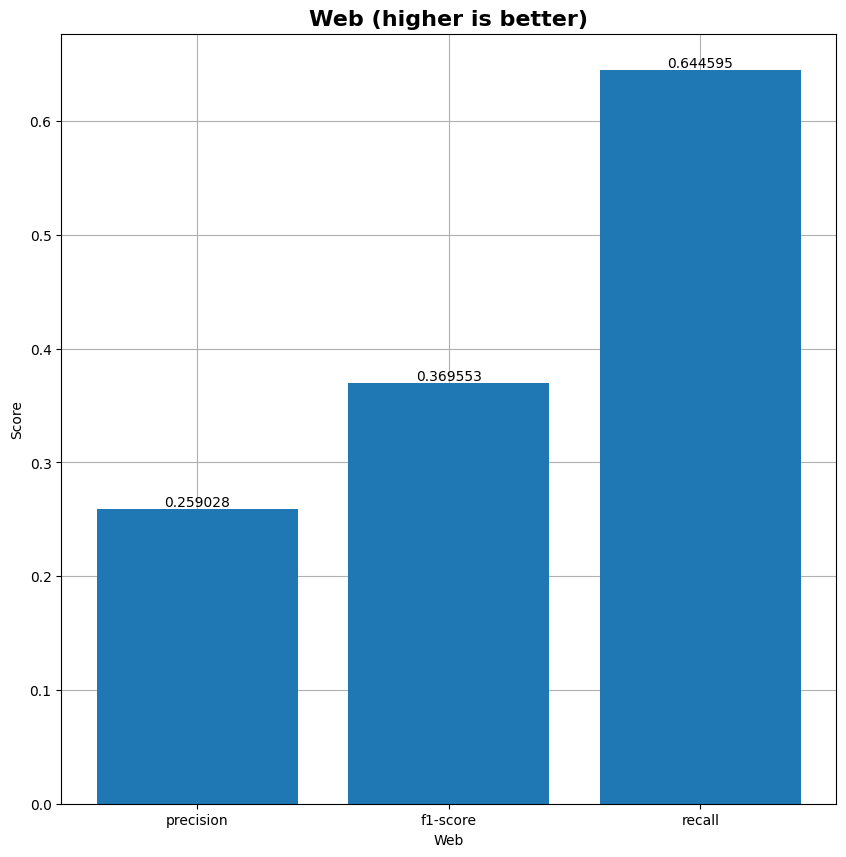

In [56]:
plot_mc(y_pred, y_test, "FF-NN")

In [57]:
model_name = "FFNN_90000.sav"
pickle.dump(model, open(model_name, 'wb'))

# LSTM

In [58]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [59]:
num_components = len(np.unique(y))

In [60]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [61]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [62]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [63]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,464 (169.78 KB)

 Trainable params: 43,464 (169.78 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

Epoch 1/10
12641/12641 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - accuracy: 0.9861 - loss: 0.0570 - val_accuracy: 0.9995 - val_loss: 0.0020
Epoch 2/10
12641/12641 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 3/10
12641/12641 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9967 - val_loss: 0.0277
Epoch 4/10
12641/12641 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9998 - val_loss: 0.0013
Epoch 5/10
12641/12641 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - accuracy: 0.9999 - loss: 8.8503e-04 - val_accuracy: 0.9999 - val_loss: 9.7997e-04
Epoch 6/10
12641/12641 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - accuracy: 0.9998 - loss: 8.3358e-04 - val_accuracy: 0.9999 - val_loss: 4.9874e-04
Epoch 7/10
12641/12641 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - accuracy: 0.9999 - loss: 5.7516e-04 - val_accuracy: 0.9998 - val_loss: 0.0021
Epoch 8/10
12641/12641 ━━━━━━━━━━━━━━━━━━━━ 84s 7

In [66]:
_, accuracy = model.evaluate(X_test, y_test)

2709/2709 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 1.0000 - loss: 1.6903e-04


In [67]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [68]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [69]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LSTM_Time]
results_dict["LSTM"] = results

In [70]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [71]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.799156,0.798558,0.796156,0.799156,0.764652,0.728416,3.635527,1.906706,53.275805
RF,0.929653,0.930075,0.928756,0.929653,0.917444,0.237887,1.120864,1.058709,31.180870
XGBoost,0.935582,0.935828,0.935125,0.935582,0.924435,0.228439,1.102718,1.050104,17.478757
LightGBM,0.907607,0.907984,0.907327,0.907607,0.891601,0.295960,1.335621,1.155691,14.549309
FF-NN,0.792811,0.790112,0.785825,0.792811,0.756313,0.567948,2.502538,1.581941,1162.719425
LSTM,0.999908,0.999908,0.999908,0.999908,0.999892,0.000311,0.001511,0.038875,851.377332


            Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.99985         1.0  1.000000  0.999925  1.000000  0.999926   
recall     0.99985         1.0  0.999926  1.000000  0.999926  0.999926   
f1-score   0.99985         1.0  0.999963  0.999963  0.999963  0.999926   

           Spoofing       Web  
precision  0.999855  0.999465  
recall     0.999782  1.000000  
f1-score   0.999818  0.999732  


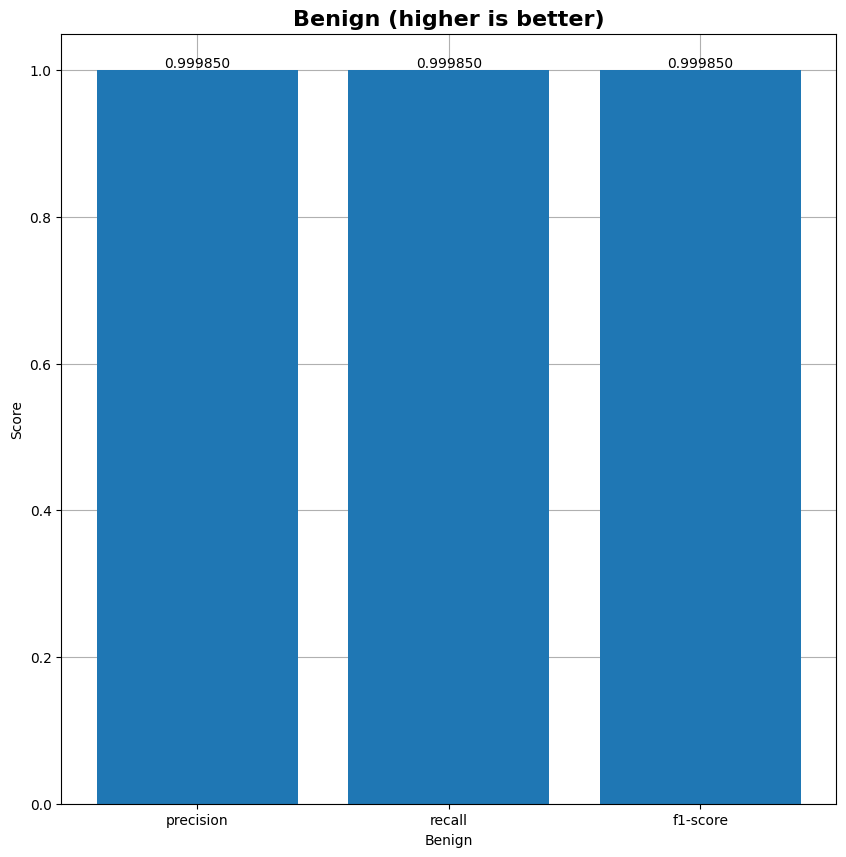

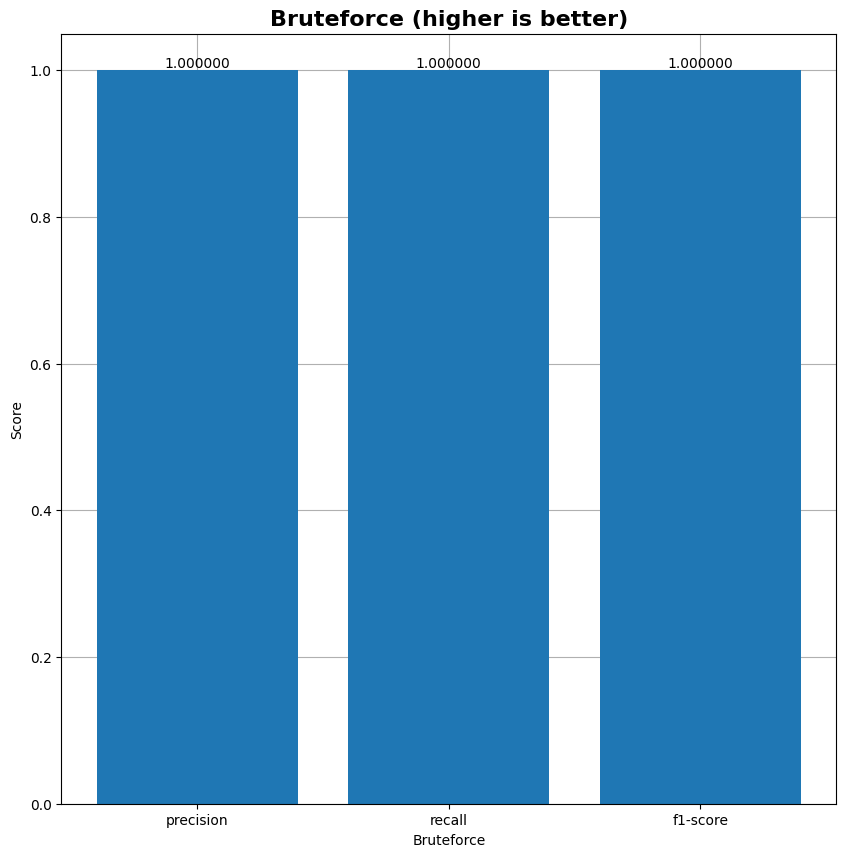

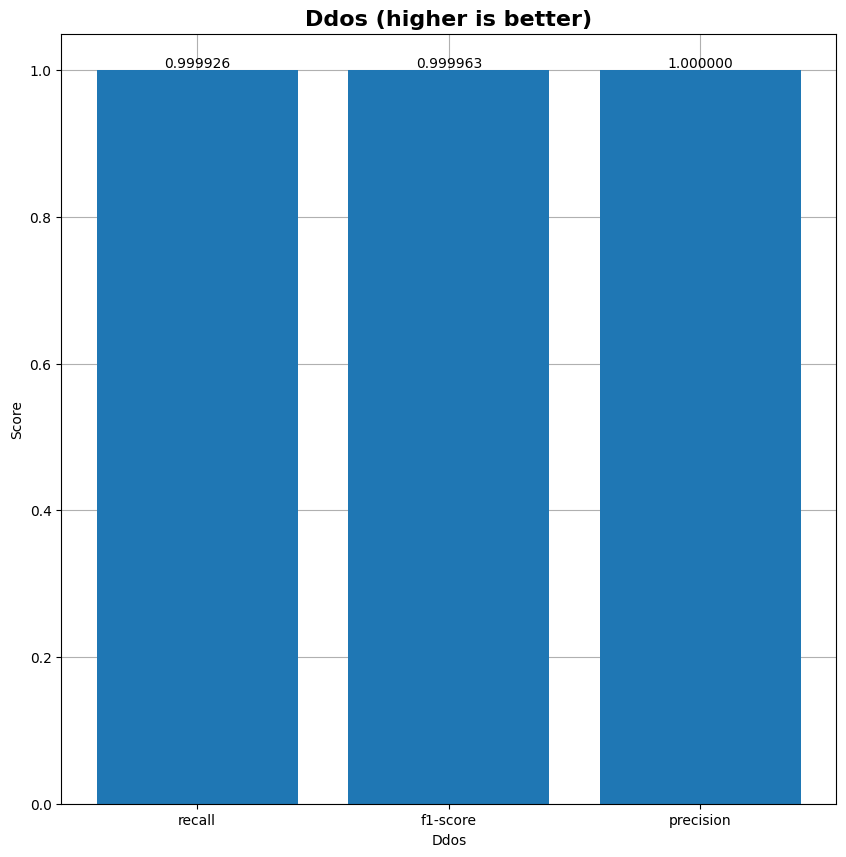

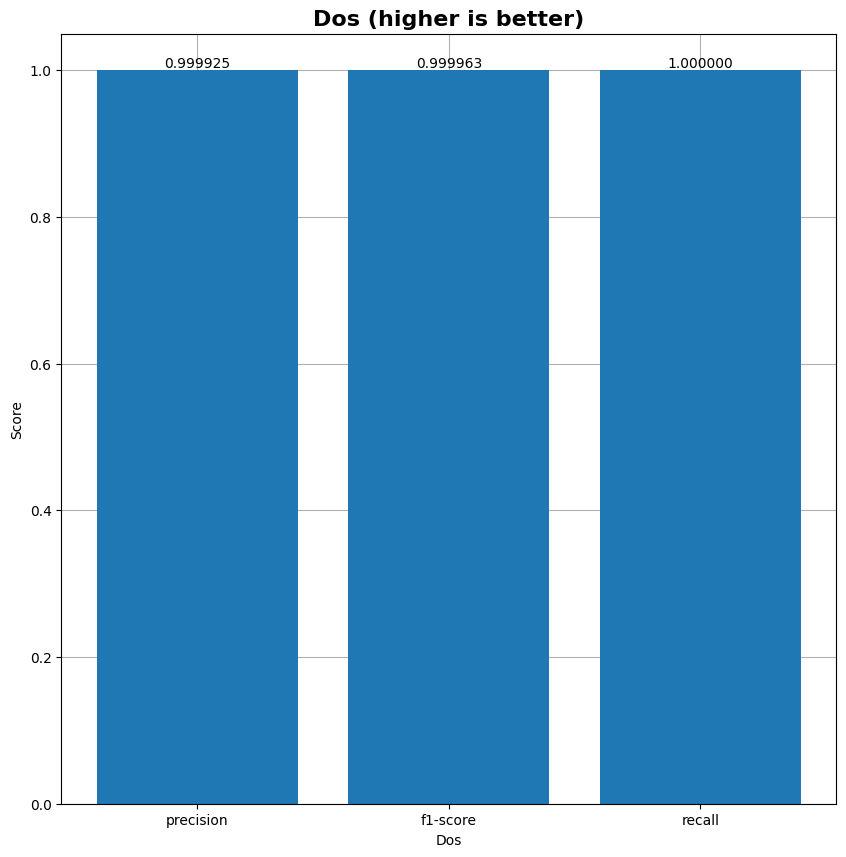

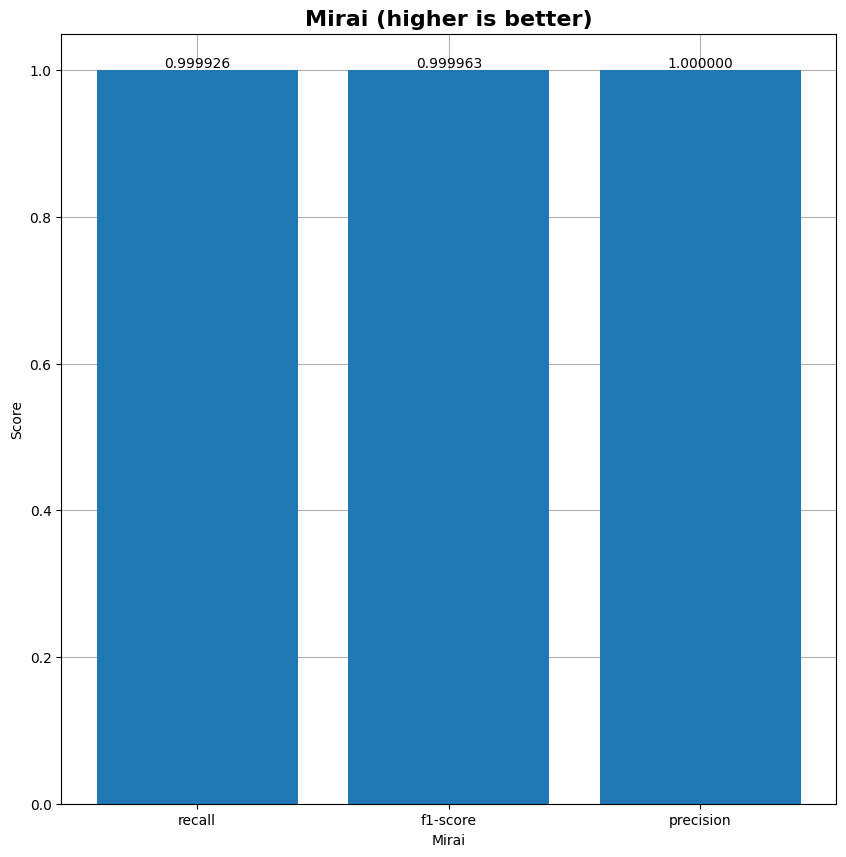

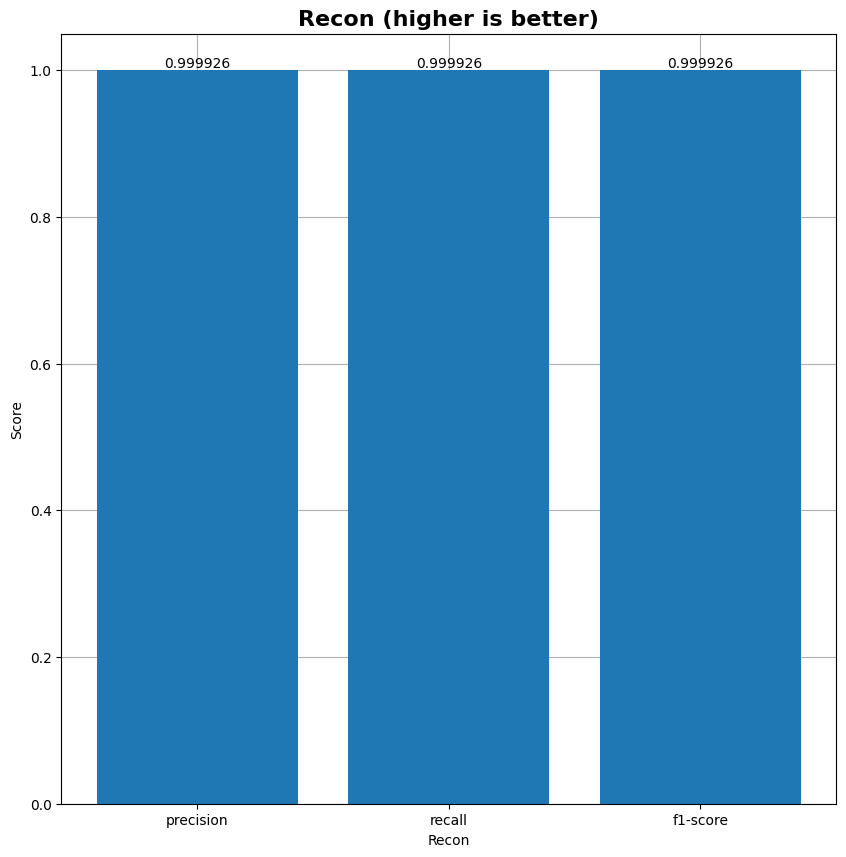

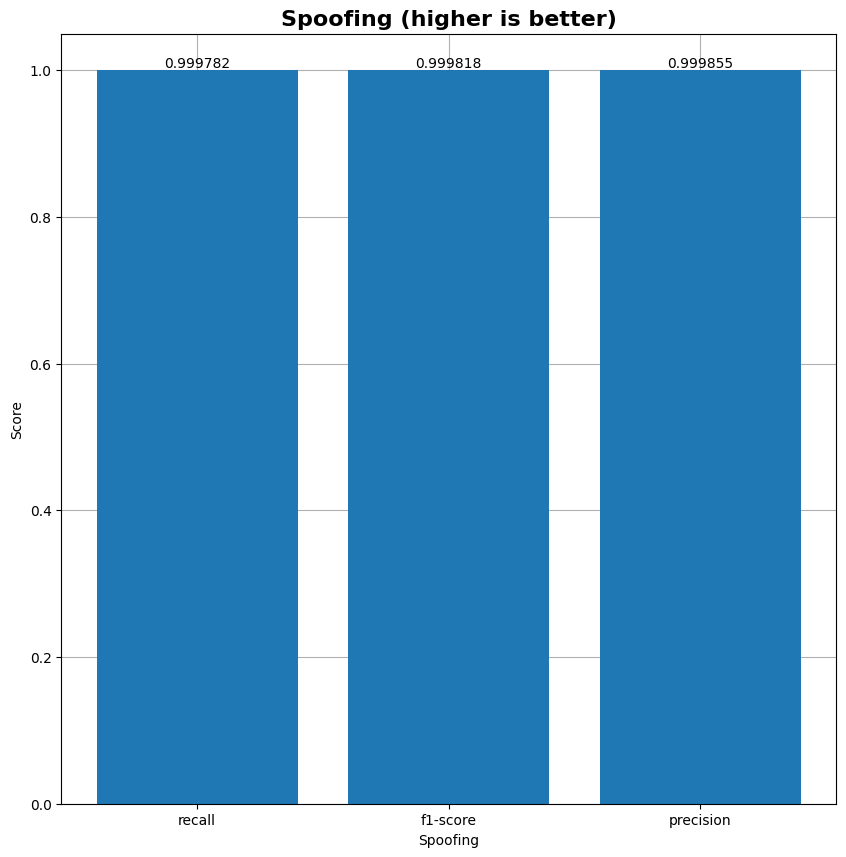

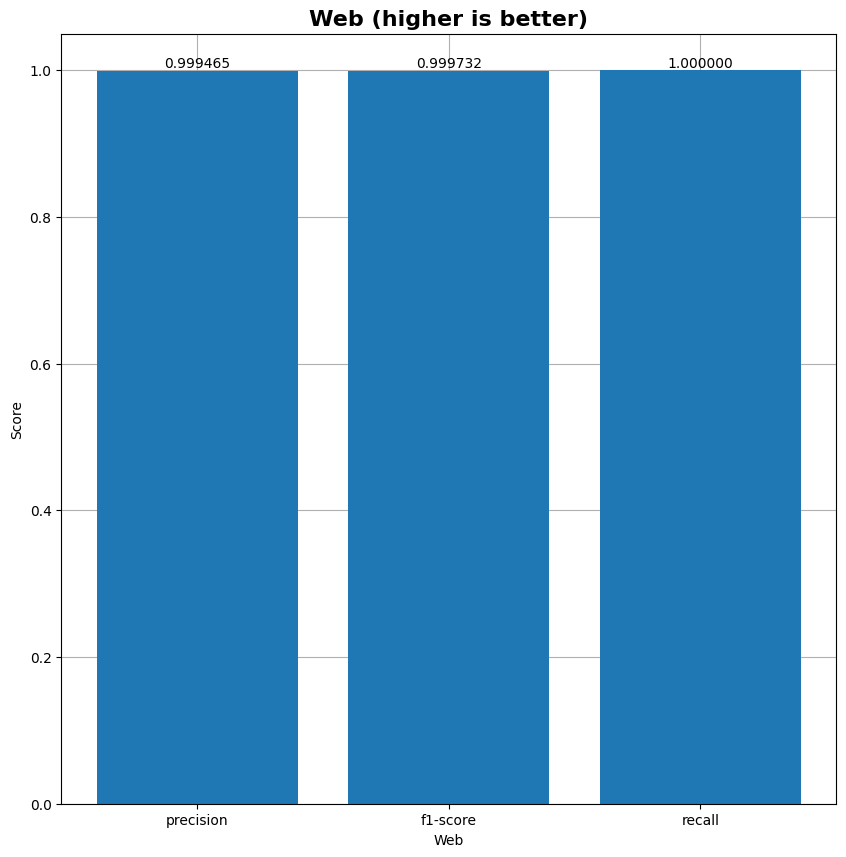

In [72]:
plot_mc(y_pred, y_test, "LSTM")

In [73]:
model_name = "LSTM_90000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Plot data

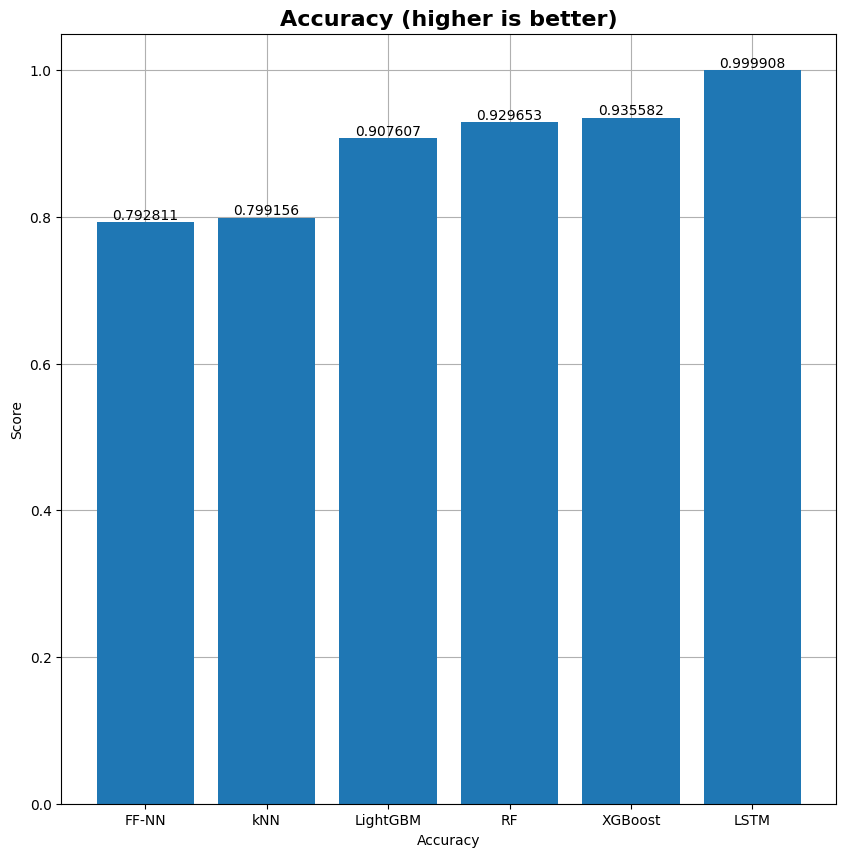

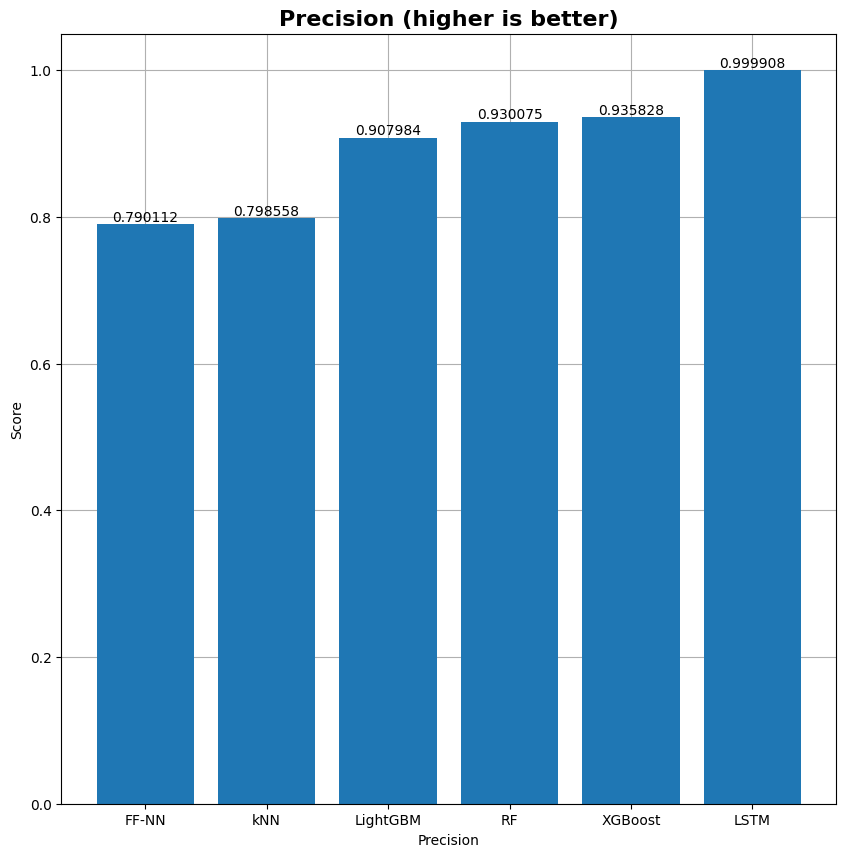

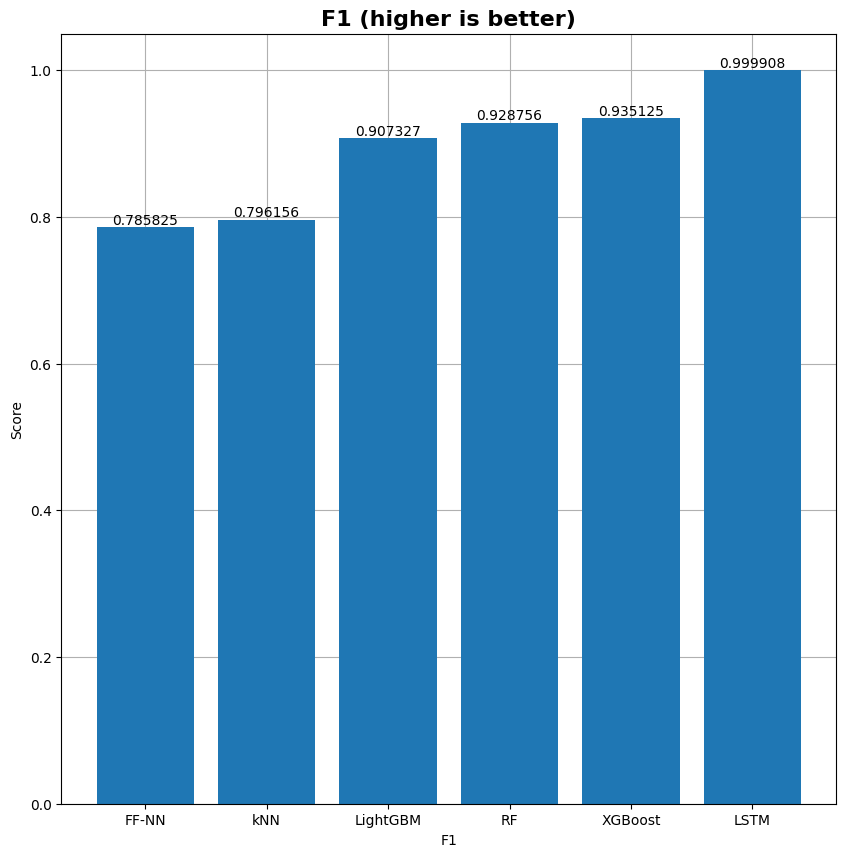

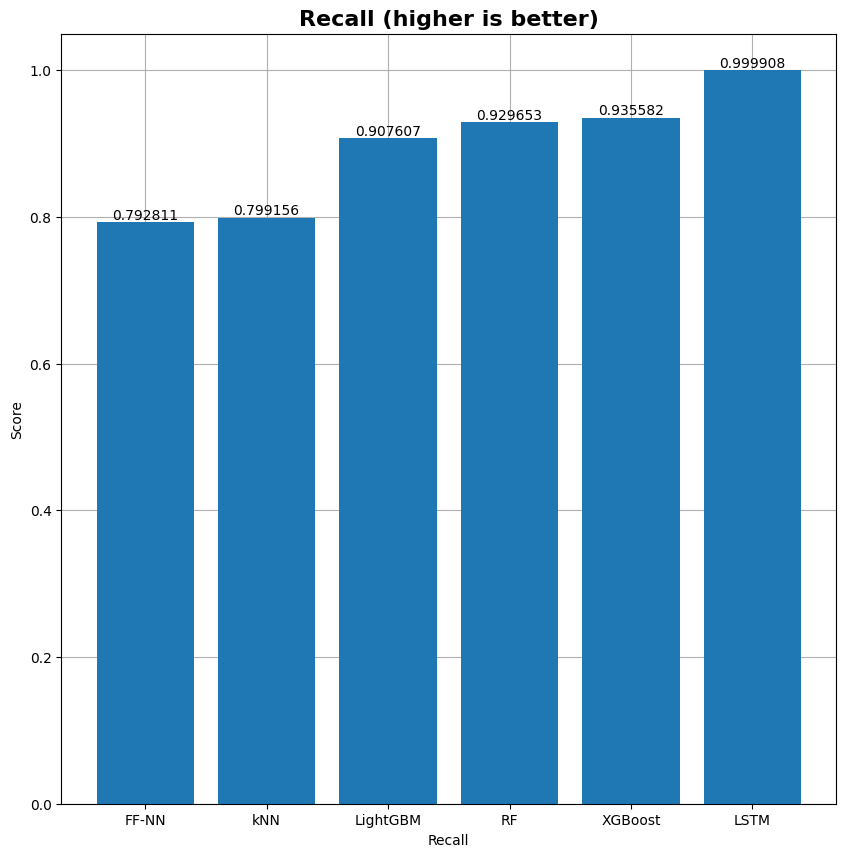

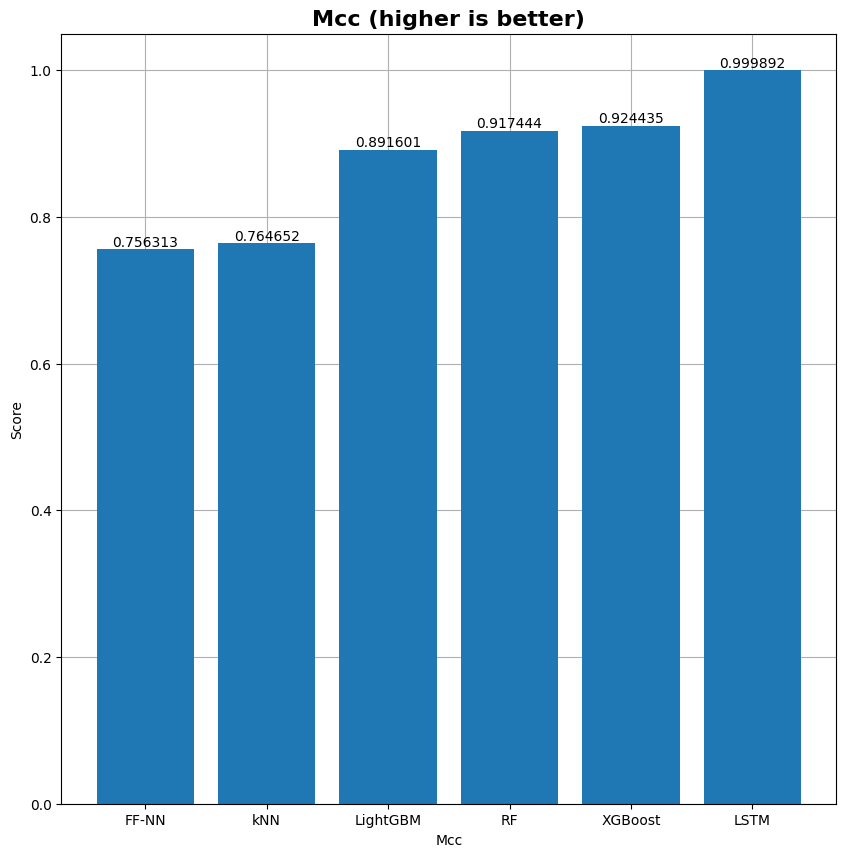

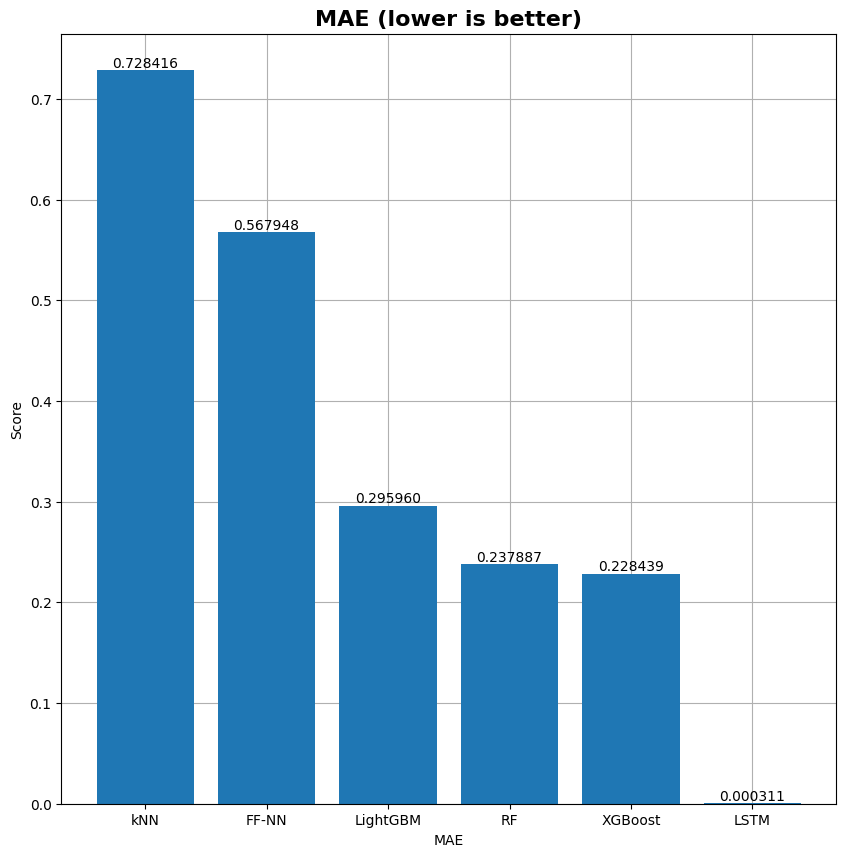

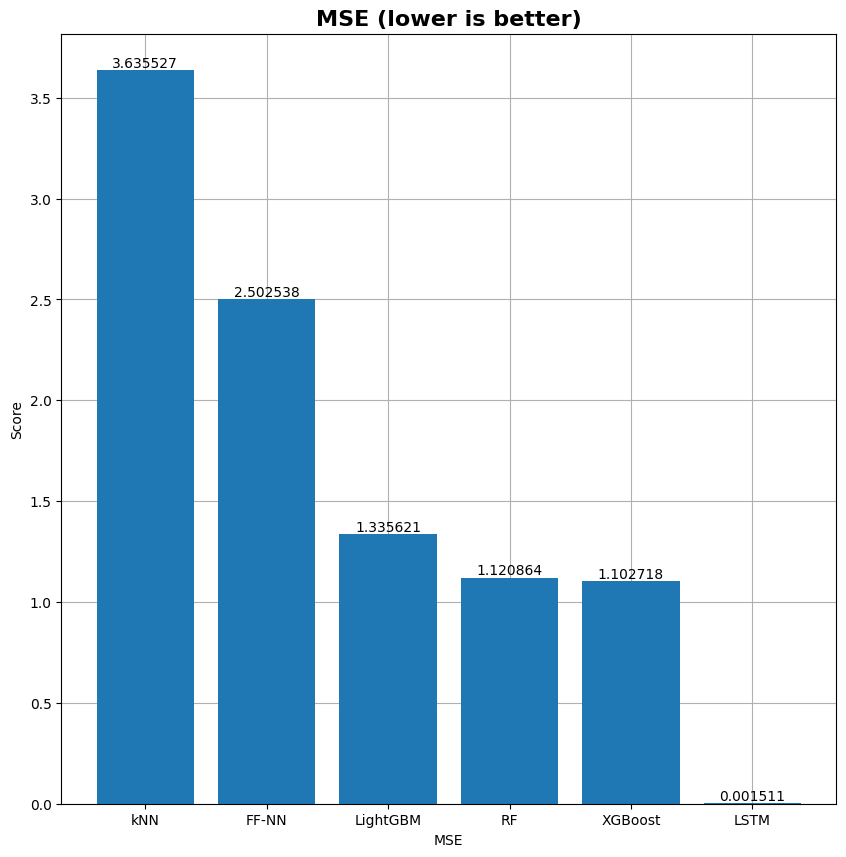

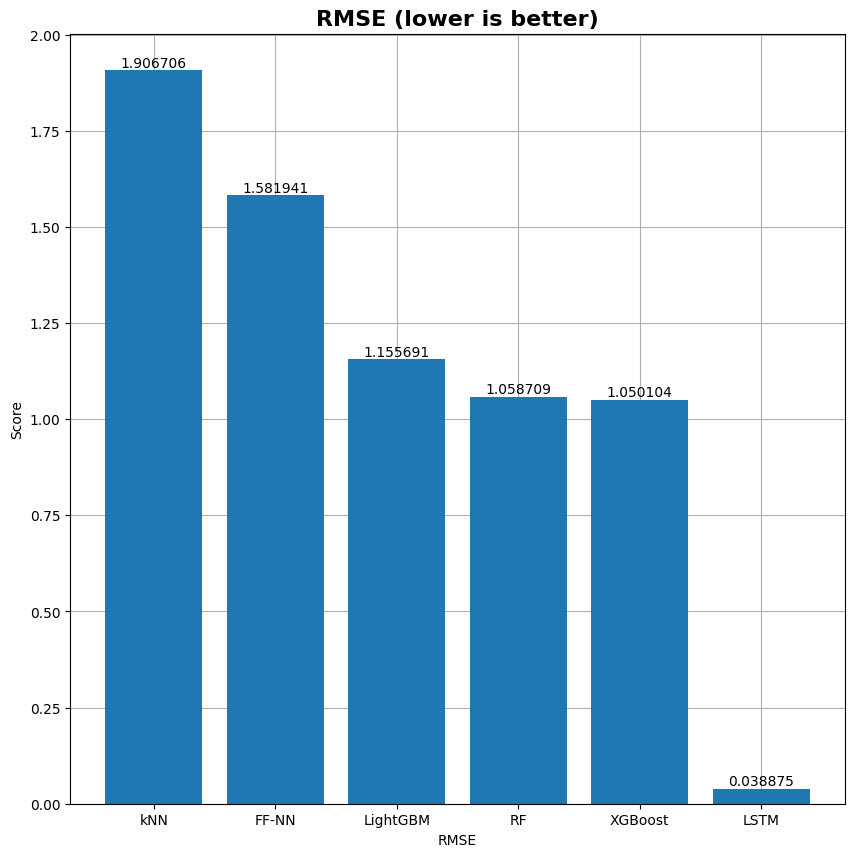

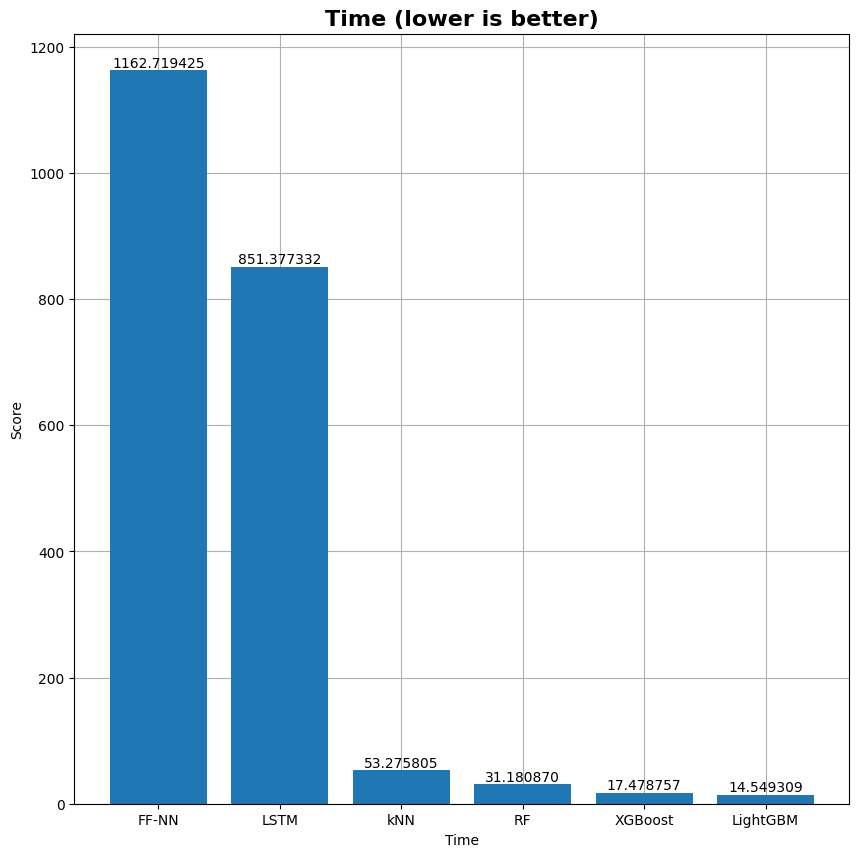

In [74]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")

# Save results dict

In [75]:
results_df.to_dict()

{'Accuracy': {'kNN': 0.7991555535046837,
  'RF': 0.9296525310322551,
  'XGBoost': 0.9355821143463615,
  'LightGBM': 0.9076069401504314,
  'FF-NN': 0.7928106784820557,
  'LSTM': 0.9999077320098877},
 'Precision': {'kNN': 0.7985584130855071,
  'RF': 0.9300753973665827,
  'XGBoost': 0.9358280320846855,
  'LightGBM': 0.9079835471794787,
  'FF-NN': 0.7901121667123466,
  'LSTM': 0.9999077117929716},
 'F1': {'kNN': 0.7961563939420342,
  'RF': 0.9287555037249678,
  'XGBoost': 0.9351249755392051,
  'LightGBM': 0.9073271657734575,
  'FF-NN': 0.7858253344074795,
  'LSTM': 0.999907705741393},
 'Recall': {'kNN': 0.7991555535046837,
  'RF': 0.9296525310322551,
  'XGBoost': 0.9355821143463615,
  'LightGBM': 0.9076069401504314,
  'FF-NN': 0.7928106686355036,
  'LSTM': 0.9999077075714401},
 'MCC': {'kNN': 0.7646515311971408,
  'RF': 0.9174438978464711,
  'XGBoost': 0.924434931378221,
  'LightGBM': 0.891601413314702,
  'FF-NN': 0.7563126941088276,
  'LSTM': 0.9998916892300943},
 'MAE': {'kNN': 0.7284158